# Importing Libraries

In [28]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

from langchain_openai import ChatOpenAI
from langchain_experimental.agents import create_pandas_dataframe_agent
from langchain.agents import create_agent

import missingno as msno



# Helper Methods

In [29]:
def is_logical_row(row) -> bool:
  """
  Logically evaluate a given row to see if it follows "Low" <= "Open"/"High" <= "Close"

  @params:
  row: pd.DataFrame row

  @reutrns:
  boolean indicating if the row is "logical"
  """
  return (
        (row['Low'] <= row['Open'] <= row['High']) and
        (row['Low'] <= row['Close'] <= row['High']) and
        (row['Volume'] > 0) and
        (row['Open Interest'] > 0) and
        all(val >= 0 for val in [row['Low'], row['Open'], row['High'], row['Close']])
    )

def add_logical_flag(df: pd.DataFrame) -> pd.DataFrame:
  """
  Adds a flag indicating "logical" entries using the
  "is_logical_row" helper method

  @params:
  df: pd.DataFrame

  @returns:
  pd.DataFrame with "is_logical" column
  """
  result = df.copy()
  result['is_logical'] = result.apply(is_logical_row, axis=1)
  return result

def summary_stats_and_hist(df: pd.DataFrame,
                           cols: list=['Open', 'High', 'Low', 'Close',
                            'Volume', 'Open Interest']) -> None:
  """
  Prints out summary stats, nullity %age and histograms for
  specified columns in an input df

  @params:
  df: pd.DataFrame
  cols: list of columns to print summary stats and histograms for
  """
  df_columns = set(df.columns)
  for col in cols:
    if col not in df_columns:
      raise ValueError(f"Column: {col} not found in dataframe")

    print(f"\nFor column: \033[1m{col}\033[0m")   # in-text ANSI for bold effect
    print("Summary Stats: ")
    print(df[col].describe())

    print("\n")
    print("Missingness: ")
    print(sum(pd.isna(df[col])) / (len(df[col]) + 0.001))   # avoiding DivdedByZero

    print("\n")
    print("Histogram:")
    plt.hist(df[col])
    plt.show()
    print('\n')


def scatter_plot(df, cols=['Open', 'High', 'Low', 'Close', 'Volume', 'Open Interest']) -> None:
  """
  Generate seaborn scatterplots for specified columns within an input dataframe

  @params:
  df: pd.DataFrame
  cols: list of columns to generate scatterplots for
  """
  df_copy = df.copy()
  for col in cols:
    sns.scatterplot(data=df_copy, x='Date', y=col)
    plt.xticks(rotation=45)  # rotate x-axis labels
    plt.tight_layout()
    plt.show()

def line_plot(df, cols=['Open', 'High', 'Low', 'Close', 'Volume', 'Open Interest']):
  """
  Generate seaborn lineplots for specified columns within an input dataframe

  @params:
  df: pd.DataFrame
  cols: list of columns to generate lineplots for
  """
  for col in cols:
    plt.figure(figsize=(12,5))
    sns.lineplot(data=tmp, x='Date', y=col)#, marker='o')
    plt.xticks(rotation=45)
    plt.show()


def between_percentiles(df, start: float=0.1, end: float=0.9, cols=['Open', 'High', 'Low', 'Close', 'Volume',
                                          'Open Interest']):
  """
  Generate a percentile map for specified columns within an input dataframe
  where key: value pairs indicate the start-end percentiles for each column

  @params:
  df: pd.DataFrame
  start: percentile float
  end: percentile float
  cols: list of columns to generate percentile map for

  @returns:
  dict
  """
  percentile_map = {}
  for each in cols:
    percentiles = df[each].quantile([start, end]).values
    percentile_map[each] = percentiles
  return percentile_map

def strip_outliers(df: pd.DataFrame, percentile_map: dict, cols: list=['Open', 'High', 'Low', 'Close', 'Volume',
                                          'Open Interest']) -> pd.DataFrame:
  """
  Returns a "sanitized" dataframe by stripping outliers based on the columns
  in the input dataframe.

  Using percentile_map as reference for values outside the start-end %tiles.

  Bitwise AND-ing ensures only non-outlier entries exist across.

  @params:
  df: pd.DataFrame
  percentile_map: dict
  cols: list of columns to identify and strip outliers

  @returns:
  pd.DataFrame
  """
  valid_idx = pd.Series(True, index=df.index)
  for col in cols:
    low, high = percentile_map[col]
    valid_idx &= df[col].between(low, high)

  return df[valid_idx].copy()   # deep copy for safety

def add_outlier_flag(df: pd.DataFrame, percentile_map: dict, cols: list=['Open', 'High', 'Low', 'Close', 'Volume',
                                          'Open Interest']) -> pd.DataFrame:

  """
  Adds columns in the format "is_colname_outlier" indicating a boolean value

  @params:
  df: pd.DataFrame
  percentile_map: dict
  cols: list of numeric columns to denote outliers

  @returns:
  pd.DataFrame with "is_colname_outlier" columns
  """

  result = df.copy()
  for col in cols:
    low, high = percentile_map[col]
    result[f'is_{col}_outlier'] = ~df[col].between(low, high)
  return result


def process_input_df(df: pd.DataFrame, symbol: str,
                     cols: list=['Open', 'High', 'Low', 'Close', 'Volume', 'Open Interest'],
                     start_percentile: float=0.1, end_percentile: float=0.9,
                     just_flag: bool=False) -> pd.DataFrame:
  """
  Runs preprocessing to eliminate NaNs, identify, extract and return
  "logical" and "non-outlier" rows as a result

  Note: if just_flag is True, only add flags indicating "logical" and "non-outlier"
  rows else return a new df with "illogical" and "outlier" rows stripped away.

  @params:
  df: pd.DataFrame
  symbol: str
  cols: list of numeric columns to process
  start_percentile: float
  end_percentile: float
  just_flag: bool (default: False)

  @returns:
  processed pd.DataFrame
  """
  fut_df = df[df['Symbol'] == symbol]
  fut_df = fut_df.dropna()
  # input 'Timestamp' follows Excel time that can be converted to YYYY-MM-DD
  fut_df['Date'] = pd.to_datetime(fut_df['Timestamp'], unit='D', origin='1899-12-30')

  # if just_flag, add required flags while RETAINING all of the original data
  # else return "processed" data with "logical" and "non-outlier" rows
  if just_flag:
    valid_fut_df = add_logical_flag(fut_df)
    percentile_map = between_percentiles(valid_fut_df, cols=cols, start=start_percentile,
                                       end=end_percentile)
    regular_valid_fut_df = add_outlier_flag(valid_fut_df, percentile_map)
  else:
    valid_fut_df = fut_df[fut_df.apply(is_logical_row, axis=1)]
    percentile_map = between_percentiles(valid_fut_df, cols=cols, start=start_percentile,
                                        end=end_percentile)
    regular_valid_fut_df = strip_outliers(valid_fut_df, percentile_map)

  return regular_valid_fut_df

def process_and_combined_input(df: pd.DataFrame,
            cols: list=['Open', 'High', 'Low', 'Close', 'Volume', 'Open Interest'],
            start_percentile: float=0.1, end_percentile: float=0.9,
            just_flag: bool=False
  ) -> pd.DataFrame:
  """
  Runs preprocessing to eliminate NaNs, identify, extract and return
  "logical" and "non-outlier" rows as a result

  @params:
  df: pd.DataFrame
  symbol: str
  cols: list of numeric columns to process
  start_percentile: float
  end_percentile: float
  just_flag: bool (default: False)

  @returns:
  processed pd.DataFrame
  """
  result = pd.DataFrame()
  for symbol in df['Symbol'].unique():
    processed_chunk = process_input_df(df=df, symbol=symbol, cols=cols,
                                       just_flag=True)
    print(f"Processed df for Symbol: {symbol}")
    result = pd.concat([result, processed_chunk])
  return result


def moving_average(df: pd.DataFrame, day_window: int=20) -> pd.DataFrame:
  df['MA'] = df['Close'].rolling(window=day_window).mean()
  return df

def exponential_moving_average(df: pd.DataFrame, day_window: int=20) -> pd.DataFrame:
  df['EMA'] = df['Close'].ewm(span=day_window, adjust=False).mean()
  return df


def time_period_ticker_statistics(df: pd.DataFrame, value_col: str, day_window: int = 10000) -> dict:
    """
    Filters df to only the last N calendar days (or start of the dataset),
    then computes cumulative return and volatility for the day_window.

    @params:
    df: pd.DataFrame
    value_col: str
    day_window: int

    @returns:
    dict with aforementioned stats for the day_window
    """
    df = df.sort_values(by='Date', ascending=True).reset_index()
    end_date = df['Date'].max()
    # if day_window is larger than the dates within the df, use earliest date found
    start_date = max(end_date - timedelta(days=day_window), df['Date'].iloc[0])

    # subset
    window = df[df['Date'] >= start_date].copy()

    # cumulative return & volatility
    start_price = window[value_col].iloc[0]
    end_price = window[value_col].iloc[-1]

    cumulative_return = 100 * (end_price - start_price) / start_price
    volatility = window[value_col].std()

    return {f'Rate of Return for "{value_col}"': cumulative_return,
            f'Volatility / St. Dev for "{value_col}"': volatility,
            f'Start':  start_date, 'End': end_date}


def plot_with_ma_ema(df, date_col, value_col, day_window: int) -> None:
    series = df[value_col]

    ma  = series.rolling(day_window).mean()
    ema = series.ewm(span=day_window, adjust=False).mean()

    fig, ax = plt.subplots(figsize=(12,5))
    ax.plot(df[date_col], series, label=value_col, linewidth=1.5)
    ax.plot(df[date_col], ma,  label=f"MA({day_window})", linewidth=1.5)
    ax.plot(df[date_col], ema, label=f"EMA({day_window})", linewidth=1.5, linestyle="--")

    ax.set_title(f"{value_col} with MA({day_window}) & EMA({day_window})")
    ax.set_xlabel(date_col)
    ax.set_ylabel(value_col)
    ax.legend()
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
    return fig, ax



# Loading the dataset

In [30]:
daily_futures = pd.read_csv("../data/raw/data_eng_assessment_dataset.csv")
# daily_futures['Timestamp'] = pd.to_datetime(daily_futures['Timestamp'])
# daily_futures['Timestamp'] = daily_futures['Timestamp'].apply(lambda x: float(x) if x else None)
daily_futures['Date'] = pd.to_datetime(daily_futures['Timestamp'], unit='D', origin='1899-12-30')
daily_futures

,Symbol,Timestamp,Open,High,Low,Close,Volume,Open Interest,Date
0,FUT1,44929.0,8.742500e+01,8.797500e+01,85.275,84.600,27911.0,69587.000000,2023-01-03
1,FUT2,44929.0,9.527500e+01,9.540000e+01,92.925,93.775,12549.0,48722.000000,2023-01-03
2,FUT3,44929.0,1.004000e+02,-2.406252e+02,98.875,99.800,33.0,84533.949147,2023-01-03
3,FUT4,44929.0,1.088750e+02,1.000000e-08,107.975,107.125,5079.0,26783.000000,2023-01-03
4,FUT5,44929.0,1.000000e-08,1.095750e+02,107.725,108.625,1563.0,11120.000000,2023-01-03
...,...,...,...,...,...,...,...,...,...
7445,FUT12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
7446,FUT12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
7447,FUT12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
7448,FUT12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


# Exploratory Data Analysis

###### This section will focus on understanding datatypes, missingness, underlying data distributions, tracking summary statistics, outliers among others   

In [31]:
daily_futures.dtypes.rename('dtype')

Symbol                   object
Timestamp               float64
Open                    float64
High                    float64
Low                     float64
Close                   float64
Volume                  float64
Open Interest           float64
Date             datetime64[ns]
Name: dtype, dtype: object

In [32]:
daily_futures['Symbol'].value_counts()

Symbol
FUT1     647
FUT2     647
FUT3     647
FUT4     647
FUT5     647
FUT6     647
FUT7     647
FUT8     647
FUT12    647
FUT11    647
FUT9     592
FUT10    388
Name: count, dtype: int64

The assignment states there are 10 tickers but 12 exist; **FUT11** and **FUT12** are present, however, **FUT9** and **FUT10** seem to have 597 and 388 entries respectively, compared to 647 for all others.

In [33]:
daily_futures.groupby('Symbol')['Timestamp'].nunique()

Symbol
FUT1     645
FUT10    388
FUT11    427
FUT12    207
FUT2     647
FUT3     647
FUT4     647
FUT5     647
FUT6     647
FUT7     647
FUT8     647
FUT9     592
Name: Timestamp, dtype: int64

## Understanding missingness, distributions and summary statistics


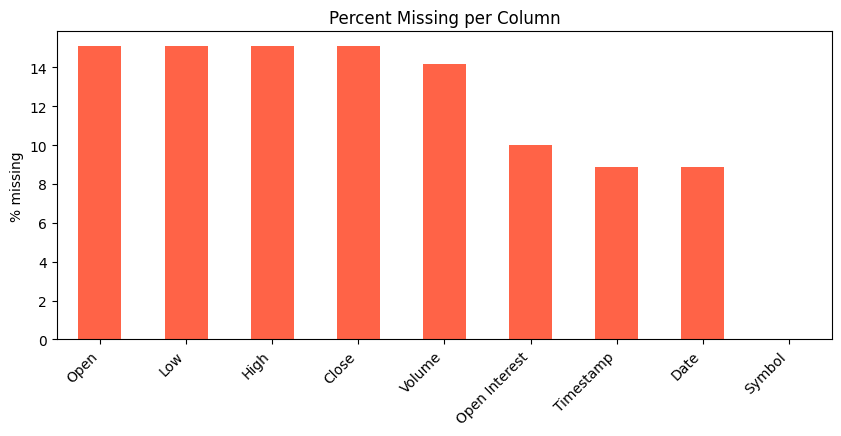

In [34]:
missing_pct = daily_futures.isna().mean().sort_values(ascending=False) * 100
missing_pct.plot(kind='bar', figsize=(10,4), color='tomato')
plt.title("Percent Missing per Column")
plt.ylabel("% missing")
plt.xticks(rotation=45, ha='right')
plt.show()



Symbol Order:  {'FUT1': 0, 'FUT2': 1, 'FUT3': 2, 'FUT4': 3, 'FUT5': 4, 'FUT6': 5, 'FUT7': 6, 'FUT8': 7, 'FUT9': 8, 'FUT10': 9, 'FUT11': 10, 'FUT12': 11}


<Axes: >

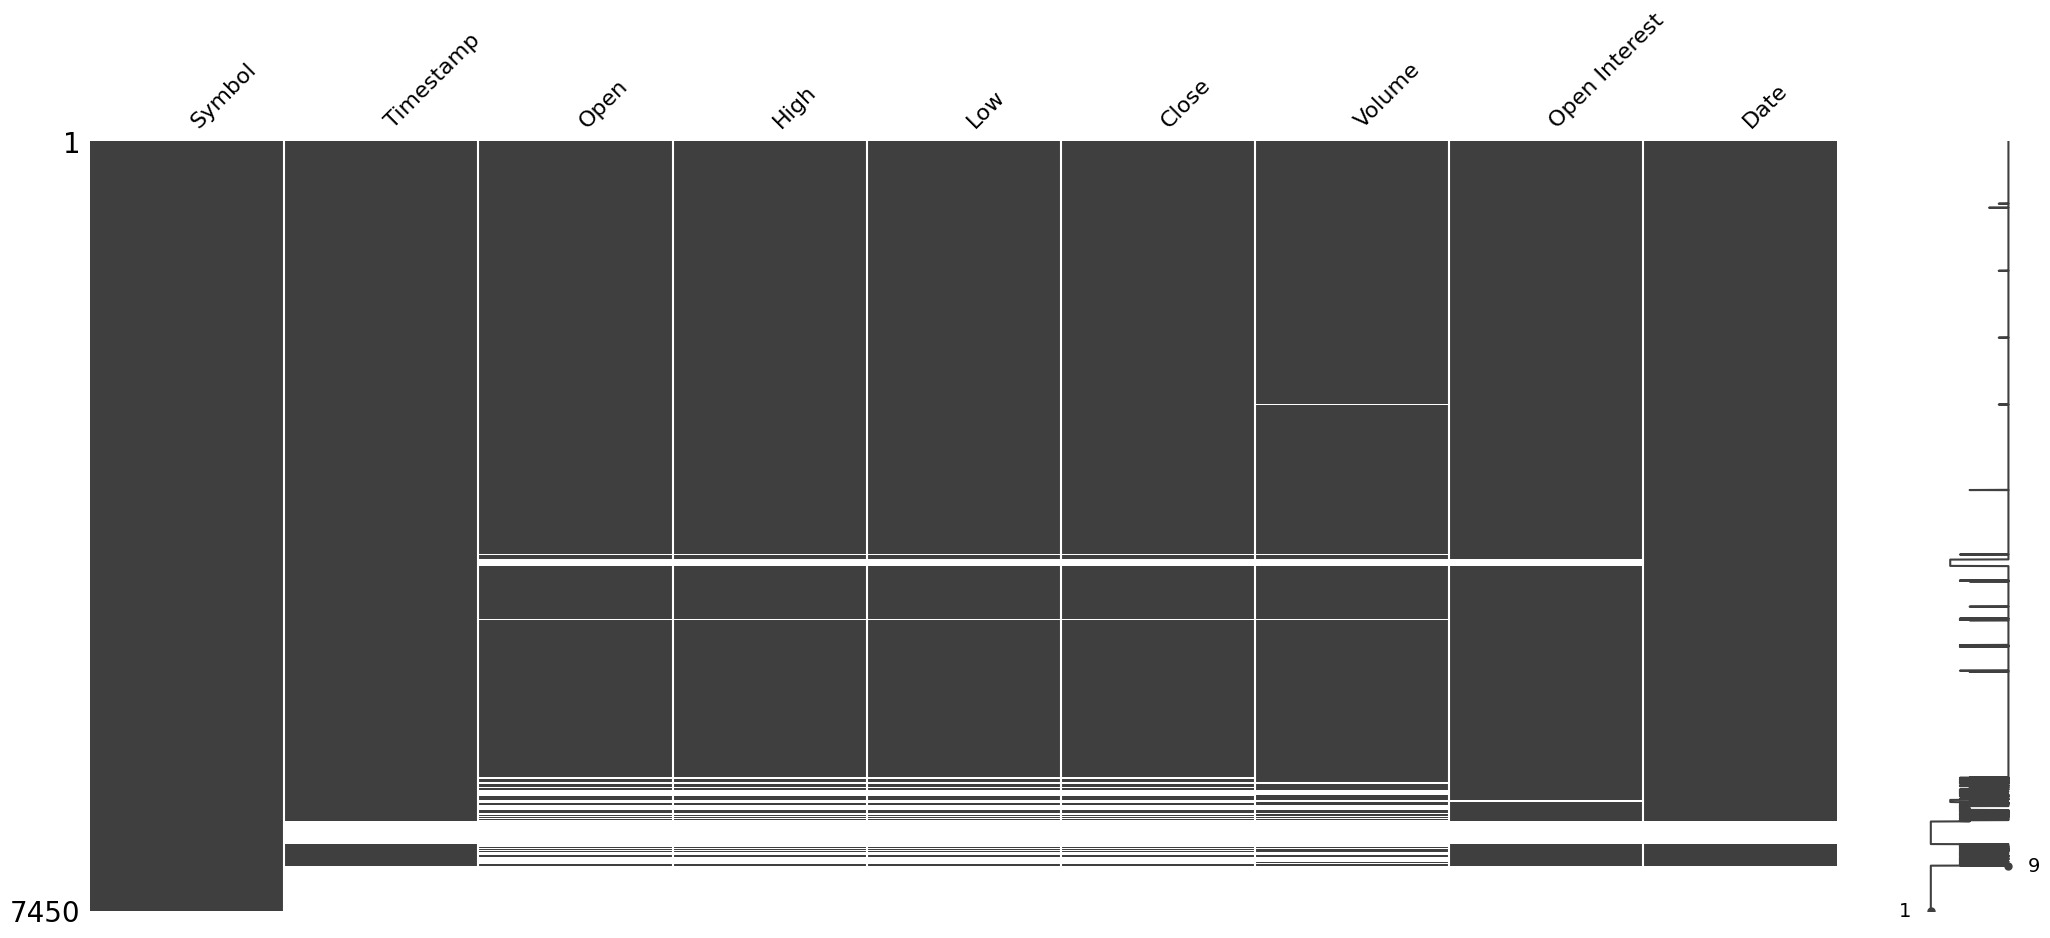

In [35]:
# sorting by Symbol and Timestamp (using the key-value map and passing in as a lambda since normal sorting wasn't
# properly ordering FUT10 and FUT11)

unique_tickers = daily_futures['Symbol'].unique()
symbol_order = {ticker: i for i, ticker in enumerate(unique_tickers)}
print("Symbol Order: ", symbol_order)


daily_futures = daily_futures.sort_values(
    by=['Symbol', 'Timestamp'],
    key=lambda col: col.map(symbol_order) if col.name == 'Symbol' else col
)

msno.matrix(daily_futures)

In [36]:
# count nulls vs non-nulls for each column for each ticker
def null_counts(x):
    return pd.Series({
        'nulls': x.isna().sum(),
        'not_nulls': x.notna().sum()
    })

null_summary = daily_futures.groupby('Symbol').apply(lambda col: col.apply(null_counts))
null_summary.sort_index(key=lambda col: col.map(symbol_order) if col.name == 'Symbol' else col)

C:\Users\shrim\AppData\Local\Temp\ipykernel_57288\2696102687.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  null_summary = daily_futures.groupby('Symbol').apply(lambda col: col.apply(null_counts))


Symbol  Timestamp  Open  High  Low  Close  Volume  \
Symbol                                                                
FUT1   not_nulls     647        645   647   647  647    647     646   
       nulls           0          2     0     0    0      0       1   
FUT2   not_nulls     647        647   647   647  647    647     646   
       nulls           0          0     0     0    0      0       1   
FUT3   not_nulls     647        647   647   647  647    647     646   
       nulls           0          0     0     0    0      0       1   
FUT4   not_nulls     647        647   647   647  647    647     646   
       nulls           0          0     0     0    0      0       1   
FUT5   not_nulls     647        647   647   647  647    647     647   
       nulls           0          0     0     0    0      0       0   
FUT6   not_nulls     647        647   646   646  646    646     647   
       nulls           0          0     1     1    1      1       0   
FUT7   not_nulls     647        647   575   575  575    575     581   
       nulls           0          0    72    72   72     72      66   
FUT8   not_nulls     647        647   624   624  624    624     628   
       nulls           0          0    23    23   23     23      19   
FUT9   not_nulls     592        592   592   592  592    592     592   
       nulls           0          0     0     0    0      0       0   
FUT10  not_nulls     388        388   388   388  388    388     388   
       nulls           0          0     0     0    0      0       0   
FUT11  not_nulls     647        427   205   205  205    205     252   
       nulls           0        220   442   442  442    442     395   
FUT12  not_nulls     647        207    60    60   60     60      73   
       nulls           0        440   587   587  587    587     574   

                  Open Interest  Date  
Symbol                                 
FUT1   not_nulls            647   645  
       nulls                  0     2  
FUT2   not_nulls            647   647  
       nulls                  0     0  
FUT3   not_nulls            647   647  
       nulls                  0     0  
FUT4   not_nulls            647   647  
       nulls                  0     0  
FUT5   not_nulls            647   647  
       nulls                  0     0  
FUT6   not_nulls            647   647  
       nulls                  0     0  
FUT7   not_nulls            584   647  
       nulls                 63     0  
FUT8   not_nulls            647   647  
       nulls                  0     0  
FUT9   not_nulls            592   592  
       nulls                  0     0  
FUT10  not_nulls            388   388  
       nulls                  0     0  
FUT11  not_nulls            405   427  
       nulls                242   220  
FUT12  not_nulls            207   207  
       nulls                440   440

In [37]:
overall_missingness = daily_futures.isnull().sum().sum()
print(f"Overall missingness (total NaN values): {overall_missingness}\n")

print("\nMissingness by column (percentage of NaN values):\n")
print((daily_futures.isnull().sum() / len(daily_futures)) * 100)

Overall missingness (total NaN values): 7627


Missingness by column (percentage of NaN values):

Symbol            0.000000
Timestamp         8.885906
Open             15.100671
High             15.100671
Low              15.100671
Close            15.100671
Volume           14.201342
Open Interest    10.000000
Date              8.885906
dtype: float64


**Conclusion:** While FUT11, FUT12 contain a very high amount of null values, FUT7 and FUT8 also contain quite a few nulls; with only `Symbol` showing no nulls whatsoever

**Overall Missingness** : None in Symbol, about 8.9% in `Timestamp`; roughly 15% each in `Open`, `Close`, `High`, `Low`, `Close`, `Volume` and 10% in `Open Interest`

In [38]:
# sorting daily_futures (FUT11, FUT12 placed somewhere between)
daily_futures.sort_values(by=['Symbol', 'Timestamp'])

,Symbol,Timestamp,Open,High,Low,Close,Volume,Open Interest,Date
0,FUT1,44929.0,8.742500e+01,87.975000,85.275,8.460000e+01,27911.000000,6.958700e+04,2023-01-03
9,FUT1,44930.0,8.487500e+01,86.025000,83.475,8.350000e+01,25940.000000,6.798900e+04,2023-01-04
18,FUT1,44931.0,8.355000e+01,83.975000,81.600,8.267500e+01,29058.000000,6.266000e+04,2023-01-05
28,FUT1,44932.0,8.232500e+01,82.350000,80.125,8.057500e+01,28988.000000,-4.315699e+06,2023-01-06
38,FUT1,44935.0,8.035000e+01,81.625000,79.700,8.100000e+01,31593.000000,5.969200e+04,2023-01-09
...,...,...,...,...,...,...,...,...,...
6744,FUT9,45863.0,9.650000e+01,96.500000,95.700,1.000000e-08,49.000000,1.244000e+03,2025-07-25
6754,FUT9,45866.0,9.622500e+01,96.525000,96.200,9.642500e+01,1898.693245,1.242000e+03,2025-07-28
6765,FUT9,45867.0,9.620000e+01,96.200000,95.200,9.537500e+01,125.000000,1.293000e+03,2025-07-29
6776,FUT9,45868.0,-1.000000e+10,95.800000,95.150,-4.185126e+02,34.000000,1.292000e+03,2025-07-30


## Histograms and Pairplots to understand distribution, spread and correlations

#### For the overall dataset, let's try looking at the data distribution and summary statistics


**Note:** The helper method `summary_stats_and_hist` displays summary stats, fraction of missingness and histograms for the input dataframe and columns


For column: Timestamp
Summary Stats: 
count     6788.000000
mean     45399.400707
std        273.809411
min      44929.000000
25%      45156.000000
50%      45398.000000
75%      45637.000000
max      45869.000000
Name: Timestamp, dtype: float64


Missingness: 
0.08885904847529551


Histogram:


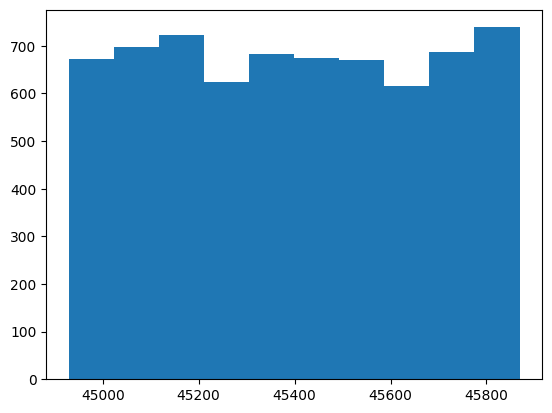




For column: Open
Summary Stats: 
count    6.325000e+03
mean    -6.325537e+16
std      6.887259e+18
min     -1.000000e+20
25%      8.020000e+01
50%      8.947500e+01
75%      1.001000e+02
max      1.000000e+20
Name: Open, dtype: float64


Missingness: 
0.15100669114004145


Histogram:


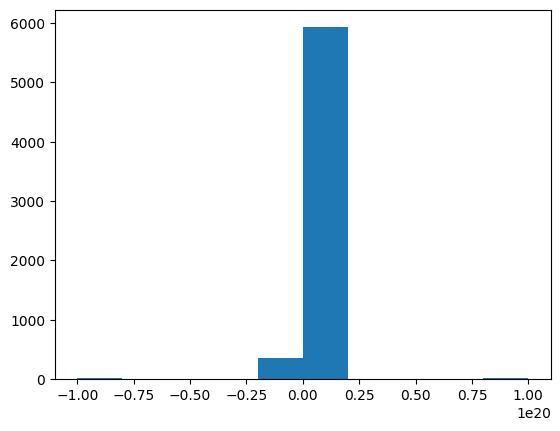




For column: Close
Summary Stats: 
count    6.325000e+03
mean    -1.119400e+14
std      7.546127e+18
min     -1.005687e+20
25%      8.007500e+01
50%      8.957500e+01
75%      1.003750e+02
max      1.000000e+20
Name: Close, dtype: float64


Missingness: 
0.15100669114004145


Histogram:


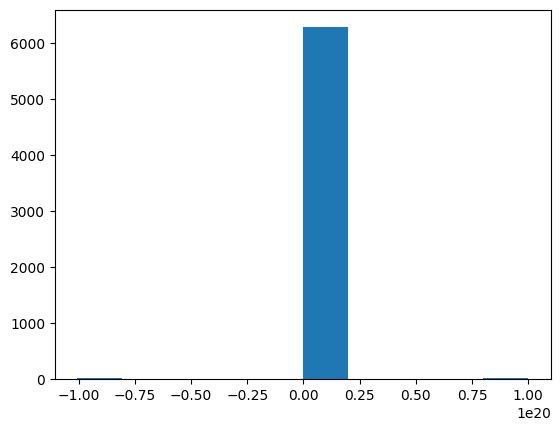




For column: High
Summary Stats: 
count    6.325000e+03
mean    -3.171391e+17
std      9.137840e+19
min     -5.345185e+21
25%      8.047500e+01
50%      9.000000e+01
75%      1.008500e+02
max      4.843482e+21
Name: High, dtype: float64


Missingness: 
0.15100669114004145


Histogram:


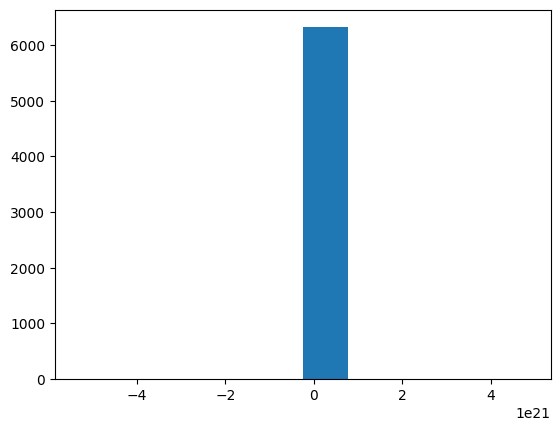




For column: Low
Summary Stats: 
count    6.325000e+03
mean    -1.484146e+18
std      9.144227e+19
min     -5.940167e+21
25%      7.950000e+01
50%      8.910000e+01
75%      9.977500e+01
max      1.000000e+20
Name: Low, dtype: float64


Missingness: 
0.15100669114004145


Histogram:


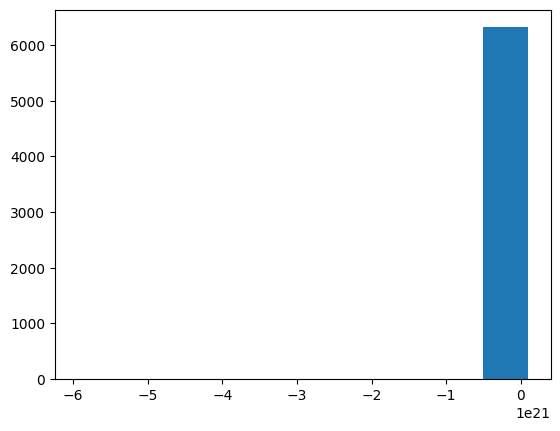




For column: Volume
Summary Stats: 
count    6.392000e+03
mean     1.095283e+17
std      7.608017e+18
min     -1.000000e+20
25%      7.000000e+01
50%      1.602500e+03
75%      7.658000e+03
max      1.000000e+20
Name: Volume, dtype: float64


Missingness: 
0.1420134037565901


Histogram:


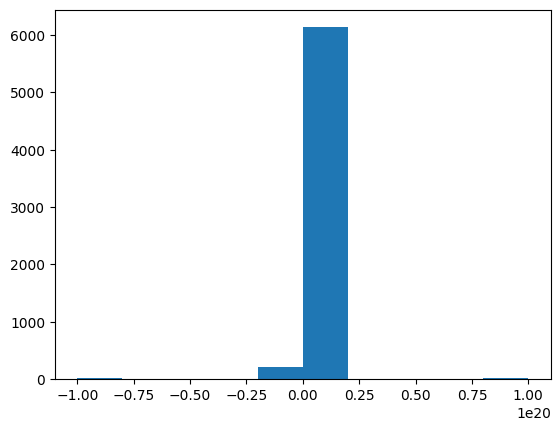




For column: Open Interest
Summary Stats: 
count    6.705000e+03
mean    -1.071223e+18
std      1.087493e+20
min     -8.882678e+21
25%      6.060000e+02
50%      8.804632e+03
75%      3.582800e+04
max      1.000000e+20
Name: Open Interest, dtype: float64


Missingness: 
0.09999998657718301


Histogram:


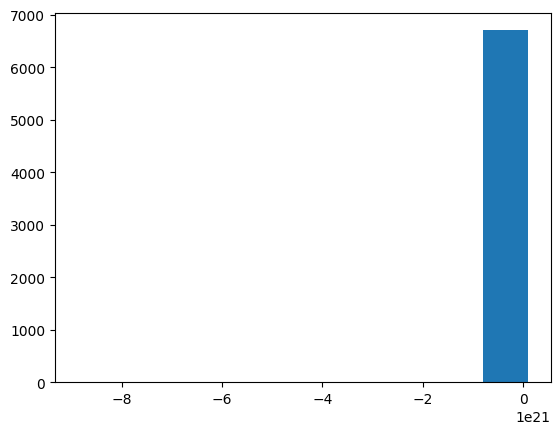

In [39]:
summary_stats_and_hist(df=daily_futures, cols=['Timestamp', 'Open', 'Close', 'High', 'Low', 'Volume', 'Open Interest'])

In [40]:
# Summary stats for all columns
daily_futures.describe()

,Timestamp,Open,High,Low,Close,Volume,Open Interest,Date
count,6788.000000,6.325000e+03,6.325000e+03,6.325000e+03,6.325000e+03,6.392000e+03,6.705000e+03,6788
mean,45399.400707,-6.325537e+16,-3.171391e+17,-1.484146e+18,-1.119400e+14,1.095283e+17,-1.071223e+18,2024-04-17 09:37:01.096051712
min,44929.000000,-1.000000e+20,-5.345185e+21,-5.940167e+21,-1.005687e+20,-1.000000e+20,-8.882678e+21,2023-01-03 00:00:00
25%,45156.000000,8.020000e+01,8.047500e+01,7.950000e+01,8.007500e+01,7.000000e+01,6.060000e+02,2023-08-18 00:00:00
50%,45398.000000,8.947500e+01,9.000000e+01,8.910000e+01,8.957500e+01,1.602500e+03,8.804632e+03,2024-04-16 00:00:00
75%,45637.000000,1.001000e+02,1.008500e+02,9.977500e+01,1.003750e+02,7.658000e+03,3.582800e+04,2024-12-11 00:00:00
max,45869.000000,1.000000e+20,4.843482e+21,1.000000e+20,1.000000e+20,1.000000e+20,1.000000e+20,2025-07-31 00:00:00
std,273.809411,6.887259e+18,9.137840e+19,9.144227e+19,7.546127e+18,7.608017e+18,1.087493e+20,NaN


**Conclusions**
1) The very high `std`, `min` and `max` values indicate the presence of huge outliers present in `Open`, `High`, `Low`, `Close`, `Volume` and `Open Interest`

2) Negative values within the matrix for `Open`, `High`, `Low`, `Close`, `Volume` and `Open Interest` also point to data integrity issues.

3) Need to eliminate outliers (accounting for only "reasonable" values to better understand trends).

## Looking for "Logical Integrity" and "Reasonable" Values


Based on the univariate histograms above, the `Timestamp` column presents a healthy and reasomable spread of data. However, that isn't the case with the other numeric columns. Thus, the motivation to extract all values between the 10th and 90th percentile for `Open`, `High`, `Low`, `Close`, `Volume` and `Open Interest` aims to capture as many "viable" values as possible. The histograms, in any case, point to how "closely packed" most of the values are so this assumption may be healthy.

The helper methods: `between_10_and_90_percentile` and `extract_regular` aim to identify only regular/reasonable numeric values for the columns above.


**Note:** :

1) The 10-90 range was determined via trial and error, further expanding the bounds would lead to including some abnormally large values.

2) We must also acknowledge that, realistically, each ticker may have its own set of "reasonable" values. So it makes more sense going forward to look at ticker-wise distributions and their spreads (more on this later).


##### Below, we would also like to see how "logical" the ticker data lines up following the principle:

1) **Low <= Open/Close <= High**             
2) **Volume/Open Interest > 0**



**Important Assumption**

During my trading experience, I have come across some situations where some obscure securities/options have zero `Volume` and `Open Interest`, but for the purposes of this assessment, I am considering only positive `Volume` / `Open Interest` to be logical.


The helper method `add_logical_flag` looks to identify rows following the implied rule above.







In [41]:
daily_futures[daily_futures.isna().any(axis=1)]


,Symbol,Timestamp,Open,High,Low,Close,Volume,Open Interest,Date
6354,FUT1,45813.0,100.250,100.900,100.000,100.750,NaN,-1.000000e+15,2025-06-05
6788,FUT1,NaN,76.625,77.125,76.625,76.625,287.0,3.699000e+03,NaT
6789,FUT1,NaN,84.050,86.950,83.825,86.100,22548.0,5.758300e+04,NaT
6358,FUT2,45813.0,105.225,105.500,103.925,104.600,NaN,8.558800e+04,2025-06-05
6359,FUT3,45813.0,107.475,107.750,106.600,106.800,NaN,8.351100e+04,2025-06-05
...,...,...,...,...,...,...,...,...,...
7445,FUT12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
7446,FUT12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
7447,FUT12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
7448,FUT12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [42]:
daily_futures_notnull = daily_futures.dropna()  # eliminates 1131
daily_futures_notnull

,Symbol,Timestamp,Open,High,Low,Close,Volume,Open Interest,Date
0,FUT1,44929.0,8.742500e+01,8.797500e+01,8.527500e+01,8.460000e+01,2.791100e+04,6.958700e+04,2023-01-03
9,FUT1,44930.0,8.487500e+01,8.602500e+01,8.347500e+01,8.350000e+01,2.594000e+04,6.798900e+04,2023-01-04
18,FUT1,44931.0,8.355000e+01,8.397500e+01,8.160000e+01,8.267500e+01,2.905800e+04,6.266000e+04,2023-01-05
28,FUT1,44932.0,8.232500e+01,8.235000e+01,8.012500e+01,8.057500e+01,2.898800e+04,-4.315699e+06,2023-01-06
38,FUT1,44935.0,8.035000e+01,8.162500e+01,7.970000e+01,8.100000e+01,3.159300e+04,5.969200e+04,2023-01-09
...,...,...,...,...,...,...,...,...,...
6345,FUT12,45812.0,-1.551712e+05,-4.118027e+03,-4.709729e+03,9.400000e+01,9.800000e+01,2.500147e+04,2025-06-04
6381,FUT12,45817.0,-5.433875e-07,-2.235757e+02,-1.000000e+20,-3.312516e+03,1.903921e-07,1.100000e+01,2025-06-09
6393,FUT12,45818.0,-1.000000e+15,-2.878332e-07,-2.617083e+05,8.150000e+01,3.925923e+11,1.100000e+01,2025-06-10
6637,FUT12,45852.0,7.350000e+01,3.079143e+03,1.000000e-08,-1.000000e+20,4.186383e+02,1.000000e-08,2025-07-14


## Examining Logical Integrity

In [43]:
daily_futures_with_is_logical = add_logical_flag(df=daily_futures_notnull)
print("Logical vs. Non-Logical Entries")
print(daily_futures_with_is_logical['is_logical'].value_counts())   # these two add up to 7450
daily_futures_only_logical = daily_futures_with_is_logical[daily_futures_with_is_logical.is_logical == True]

Logical vs. Non-Logical Entries
is_logical
True     3334
False    2985
Name: count, dtype: int64


In [44]:
daily_futures_with_is_logical

,Symbol,Timestamp,Open,High,Low,Close,Volume,Open Interest,Date,is_logical
0,FUT1,44929.0,8.742500e+01,8.797500e+01,8.527500e+01,8.460000e+01,2.791100e+04,6.958700e+04,2023-01-03,False
9,FUT1,44930.0,8.487500e+01,8.602500e+01,8.347500e+01,8.350000e+01,2.594000e+04,6.798900e+04,2023-01-04,True
18,FUT1,44931.0,8.355000e+01,8.397500e+01,8.160000e+01,8.267500e+01,2.905800e+04,6.266000e+04,2023-01-05,True
28,FUT1,44932.0,8.232500e+01,8.235000e+01,8.012500e+01,8.057500e+01,2.898800e+04,-4.315699e+06,2023-01-06,False
38,FUT1,44935.0,8.035000e+01,8.162500e+01,7.970000e+01,8.100000e+01,3.159300e+04,5.969200e+04,2023-01-09,True
...,...,...,...,...,...,...,...,...,...,...
6345,FUT12,45812.0,-1.551712e+05,-4.118027e+03,-4.709729e+03,9.400000e+01,9.800000e+01,2.500147e+04,2025-06-04,False
6381,FUT12,45817.0,-5.433875e-07,-2.235757e+02,-1.000000e+20,-3.312516e+03,1.903921e-07,1.100000e+01,2025-06-09,False
6393,FUT12,45818.0,-1.000000e+15,-2.878332e-07,-2.617083e+05,8.150000e+01,3.925923e+11,1.100000e+01,2025-06-10,False
6637,FUT12,45852.0,7.350000e+01,3.079143e+03,1.000000e-08,-1.000000e+20,4.186383e+02,1.000000e-08,2025-07-14,False


In [46]:
daily_futures_only_logical

,Symbol,Timestamp,Open,High,Low,Close,Volume,Open Interest,Date,is_logical
9,FUT1,44930.0,84.875,86.025000,83.475,83.500,2.594000e+04,67989.0,2023-01-04,True
18,FUT1,44931.0,83.550,83.975000,81.600,82.675,2.905800e+04,62660.0,2023-01-05,True
38,FUT1,44935.0,80.350,81.625000,79.700,81.000,3.159300e+04,59692.0,2023-01-09,True
57,FUT1,44937.0,79.800,80.150000,78.825,79.225,2.540500e+04,48890.0,2023-01-11,True
77,FUT1,44939.0,78.550,79.400000,77.675,78.525,2.437500e+04,39402.0,2023-01-13,True
...,...,...,...,...,...,...,...,...,...,...
6526,FUT11,45835.0,81.550,3027.321351,81.550,81.550,1.000000e+00,15.0,2025-06-27,True
6581,FUT11,45845.0,80.950,81.075000,80.950,81.075,1.800000e+01,46.0,2025-07-07,True
6592,FUT11,45846.0,80.350,80.350000,80.350,80.350,5.000000e+00,48.0,2025-07-08,True
6625,FUT11,45849.0,80.550,80.700000,80.550,80.550,1.000000e-08,104.0,2025-07-11,True


Next, we will look for only "reasonabe" i.e. non-outlier rows present.

Any row containing an "outlier value" (based on our 10-90 percentile rule above) in *any* numerical column will be flagged.


**Note:** The helper method `add_outlier_flag` adds columns in the format "is_colname_outlier" indicating a boolean value

In [47]:
# generating percentile maps for a given dataframe
percentile_map_all = between_percentiles(df=daily_futures_only_logical, start=0.10, end=0.90, cols=['Open', 'High', 'Low', 'Close', 'Volume', 'Open Interest'])
print("Percentil Map: ")
print(percentile_map_all)
daily_futures_only_logical_with_is_outliers = add_outlier_flag(df=daily_futures_only_logical, percentile_map=percentile_map_all)

print("Total Rows: ", len(daily_futures))
print('Total "Logical" Rows: ', len(daily_futures_only_logical))

num_any_nan = daily_futures.isna().any(axis=1).sum()
print("Rows with any NaN:", num_any_nan)
daily_futures_only_logical_with_is_outliers

Percentil Map: 
{'Open': array([  76., 9211.]), 'High': array([  76.85, 9918.25]), 'Low': array([  74.75, 8939.75]), 'Close': array([  76.125, 9265.25 ]), 'Volume': array([   37. , 21866.5]), 'Open Interest': array([  517. , 87013.9])}
Total Rows:  7450
Total "Logical" Rows:  3334
Rows with any NaN: 1131


,Symbol,Timestamp,Open,High,Low,Close,Volume,Open Interest,Date,is_logical,is_Open_outlier,is_High_outlier,is_Low_outlier,is_Close_outlier,is_Volume_outlier,is_Open Interest_outlier
9,FUT1,44930.0,84.875,86.025000,83.475,83.500,2.594000e+04,67989.0,2023-01-04,True,False,False,False,False,True,False
18,FUT1,44931.0,83.550,83.975000,81.600,82.675,2.905800e+04,62660.0,2023-01-05,True,False,False,False,False,True,False
38,FUT1,44935.0,80.350,81.625000,79.700,81.000,3.159300e+04,59692.0,2023-01-09,True,False,False,False,False,True,False
57,FUT1,44937.0,79.800,80.150000,78.825,79.225,2.540500e+04,48890.0,2023-01-11,True,False,False,False,False,True,False
77,FUT1,44939.0,78.550,79.400000,77.675,78.525,2.437500e+04,39402.0,2023-01-13,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6526,FUT11,45835.0,81.550,3027.321351,81.550,81.550,1.000000e+00,15.0,2025-06-27,True,False,False,False,False,True,True
6581,FUT11,45845.0,80.950,81.075000,80.950,81.075,1.800000e+01,46.0,2025-07-07,True,False,False,False,False,True,True
6592,FUT11,45846.0,80.350,80.350000,80.350,80.350,5.000000e+00,48.0,2025-07-08,True,False,False,False,False,True,True
6625,FUT11,45849.0,80.550,80.700000,80.550,80.550,1.000000e-08,104.0,2025-07-11,True,False,False,False,False,True,True


Now, extracting out rows with "no-outliers" present and that are logical

In [48]:
daily_fixtures_only_logical_no_outliers = strip_outliers(df=daily_futures_only_logical_with_is_outliers, percentile_map=percentile_map_all)
daily_fixtures_only_logical_no_outliers

,Symbol,Timestamp,Open,High,Low,Close,Volume,Open Interest,Date,is_logical,is_Open_outlier,is_High_outlier,is_Low_outlier,is_Close_outlier,is_Volume_outlier,is_Open Interest_outlier
107,FUT1,44945.0,77.175,77.650000,76.400,76.600,15369.0,32492.0,2023-01-19,True,False,False,False,False,False,False
117,FUT1,44946.0,77.150,78.550000,76.900,78.175,11023.0,31326.0,2023-01-20,True,False,False,False,False,False,False
127,FUT1,44949.0,77.850,78.200000,77.075,77.750,7873.0,30239.0,2023-01-23,True,False,False,False,False,False,False
137,FUT1,44950.0,78.000,78.100000,76.425,77.050,10013.0,29279.0,2023-01-24,True,False,False,False,False,False,False
147,FUT1,44951.0,77.150,77.350000,76.300,76.900,6214.0,28827.0,2023-01-25,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6536,FUT10,45838.0,97.000,97.000000,96.250,96.850,141.0,627.0,2025-06-30,True,False,False,False,False,False,False
6580,FUT10,45845.0,96.200,97.150000,96.200,97.000,45.0,650.0,2025-07-07,True,False,False,False,False,False,False
6647,FUT10,45853.0,94.700,94.800000,94.175,94.475,65.0,1017.0,2025-07-15,True,False,False,False,False,False,False
3180,FUT11,45370.0,93.300,93.300000,93.300,93.300,253.0,845.0,2024-03-19,True,False,False,False,False,False,False


In [49]:
daily_fixtures_only_logical_no_outliers['is_logical'].value_counts()

is_logical
True    1745
Name: count, dtype: int64

In [50]:
# confirming that only False values exist for the following in the table
daily_fixtures_only_logical_no_outliers[
    ['is_Open_outlier', 'is_Close_outlier', 'is_Low_outlier', 'is_High_outlier', 'is_Open Interest_outlier', 'is_Volume_outlier']
  ].value_counts()

is_Open_outlier  is_Close_outlier  is_Low_outlier  is_High_outlier  is_Open Interest_outlier  is_Volume_outlier
False            False             False           False            False                     False                1745
Name: count, dtype: int64

In [51]:
# verified
tmp = add_outlier_flag(df=daily_futures_only_logical, percentile_map=percentile_map_all)
tmp[(tmp['is_logical'] == True) &
 (tmp['is_Open_outlier'] == False) &
  (tmp['is_Close_outlier'] == False) &
    (tmp['is_Low_outlier'] == False) &
    (tmp['is_High_outlier'] == False) &
    (tmp['is_Volume_outlier'] == False) &
    (tmp['is_Open Interest_outlier'] == False)
  ]

,Symbol,Timestamp,Open,High,Low,Close,Volume,Open Interest,Date,is_logical,is_Open_outlier,is_High_outlier,is_Low_outlier,is_Close_outlier,is_Volume_outlier,is_Open Interest_outlier
107,FUT1,44945.0,77.175,77.650000,76.400,76.600,15369.0,32492.0,2023-01-19,True,False,False,False,False,False,False
117,FUT1,44946.0,77.150,78.550000,76.900,78.175,11023.0,31326.0,2023-01-20,True,False,False,False,False,False,False
127,FUT1,44949.0,77.850,78.200000,77.075,77.750,7873.0,30239.0,2023-01-23,True,False,False,False,False,False,False
137,FUT1,44950.0,78.000,78.100000,76.425,77.050,10013.0,29279.0,2023-01-24,True,False,False,False,False,False,False
147,FUT1,44951.0,77.150,77.350000,76.300,76.900,6214.0,28827.0,2023-01-25,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6536,FUT10,45838.0,97.000,97.000000,96.250,96.850,141.0,627.0,2025-06-30,True,False,False,False,False,False,False
6580,FUT10,45845.0,96.200,97.150000,96.200,97.000,45.0,650.0,2025-07-07,True,False,False,False,False,False,False
6647,FUT10,45853.0,94.700,94.800000,94.175,94.475,65.0,1017.0,2025-07-15,True,False,False,False,False,False,False
3180,FUT11,45370.0,93.300,93.300000,93.300,93.300,253.0,845.0,2024-03-19,True,False,False,False,False,False,False


Thus, through strictly disregarding "illogical" and "outlier" entries, we can more confidently look at data distributions/trends.

However, this has led to a sizeable reduction in our dataset from 7450 to 1745 rows.

**Conclusion:**

1) There are high instances of data integrity issues - out of 7450 rows, only 3334 rows are "logical" following our 2 rule constraints of Low <= Open/Close <= High and Volume/Open Interest > 0.

This is a significant but necessary reduction because including these would clearly point to data integrity issues.

2) Of the 3334 rows that are "logical", we adopt a 10-90 percentile range - any numerical value outside this range for `Open`, `Close`, `Low`, `High`, `Open Interest` and `Volume` count as outliers.

We are thus eventually left with 1745 "logical" rows with "non-outlier" values throuhgout.






For column: Timestamp
Summary Stats: 
count     1745.000000
mean     45386.132378
std        281.375751
min      44929.000000
25%      45146.000000
50%      45371.000000
75%      45636.000000
max      45869.000000
Name: Timestamp, dtype: float64


Missingness: 
0.0


Histogram:


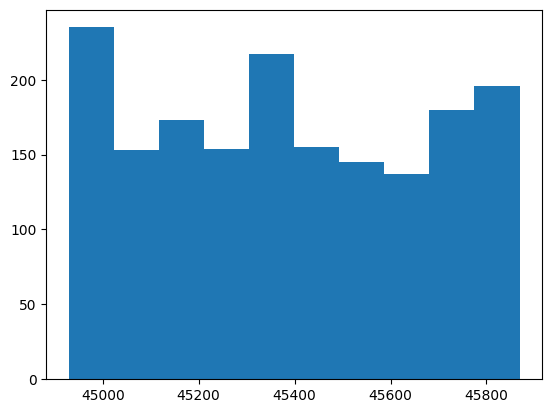




For column: Open
Summary Stats: 
count    1745.000000
mean      700.296576
std      2129.582379
min        76.000000
25%        83.400000
50%        90.775000
75%        97.650000
max      9092.500000
Name: Open, dtype: float64


Missingness: 
0.0


Histogram:


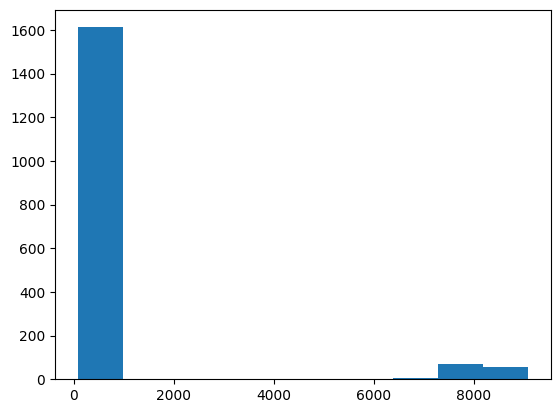




For column: Close
Summary Stats: 
count    1745.000000
mean      699.680860
std      2127.466082
min        76.125000
25%        83.275000
50%        90.750000
75%        97.700000
max      8890.000000
Name: Close, dtype: float64


Missingness: 
0.0


Histogram:


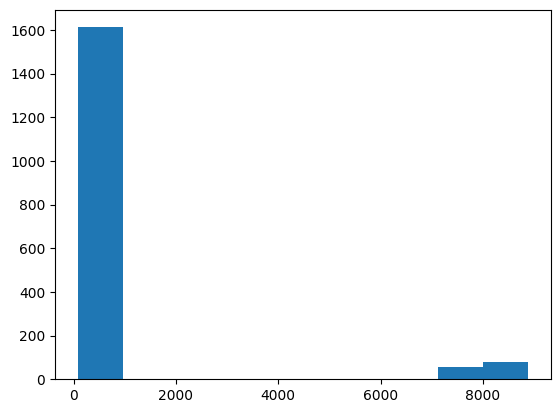




For column: High
Summary Stats: 
count    1745.000000
mean      800.526139
std      2227.804877
min        76.850000
25%        84.050000
50%        91.600000
75%        98.775000
max      9125.000000
Name: High, dtype: float64


Missingness: 
0.0


Histogram:


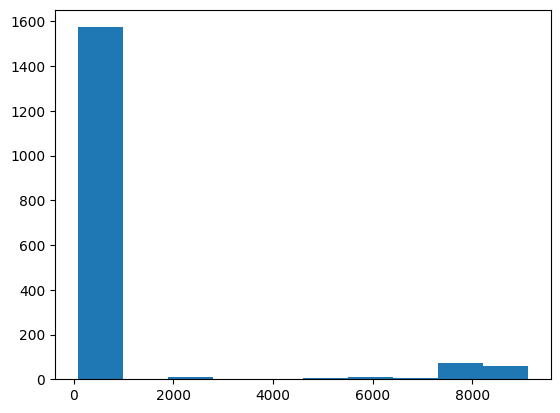




For column: Low
Summary Stats: 
count    1745.000000
mean      694.884699
std      2113.027125
min        75.325000
25%        82.725000
50%        90.275000
75%        97.075000
max      8840.000000
Name: Low, dtype: float64


Missingness: 
0.0


Histogram:


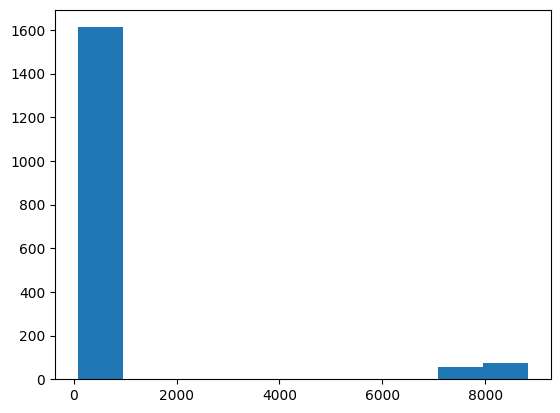




For column: Volume
Summary Stats: 
count     1745.000000
mean      3876.595451
std       4440.267208
min         37.000000
25%        439.000000
50%       2281.000000
75%       5759.000000
max      21825.000000
Name: Volume, dtype: float64


Missingness: 
0.0


Histogram:


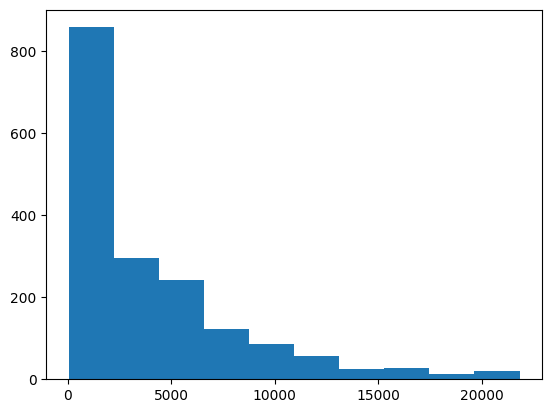




For column: Open Interest
Summary Stats: 
count     1745.000000
mean     19583.164339
std      18973.622391
min        517.000000
25%       3928.000000
50%      14784.000000
75%      30008.000000
max      86494.000000
Name: Open Interest, dtype: float64


Missingness: 
0.0


Histogram:


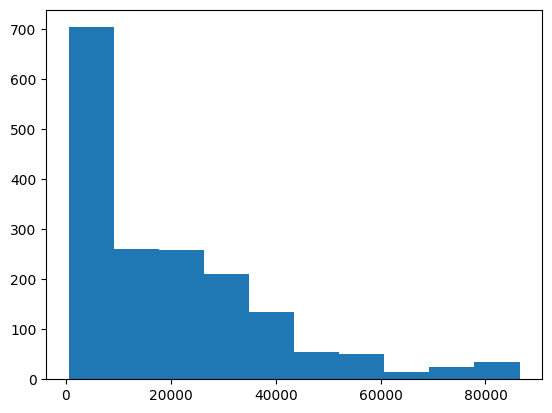

In [52]:
summary_stats_and_hist(df=daily_fixtures_only_logical_no_outliers, cols=['Timestamp', 'Open', 'Close', 'High', 'Low', 'Volume', 'Open Interest'])

**Conclusion**: With outliers gone and "logical" values allowed, the scale of the data looks more feasible - naturally, there is still a high degree of "Right Skewness" in the data but we shall try conducting ticker-wise analysis to better understand the data.

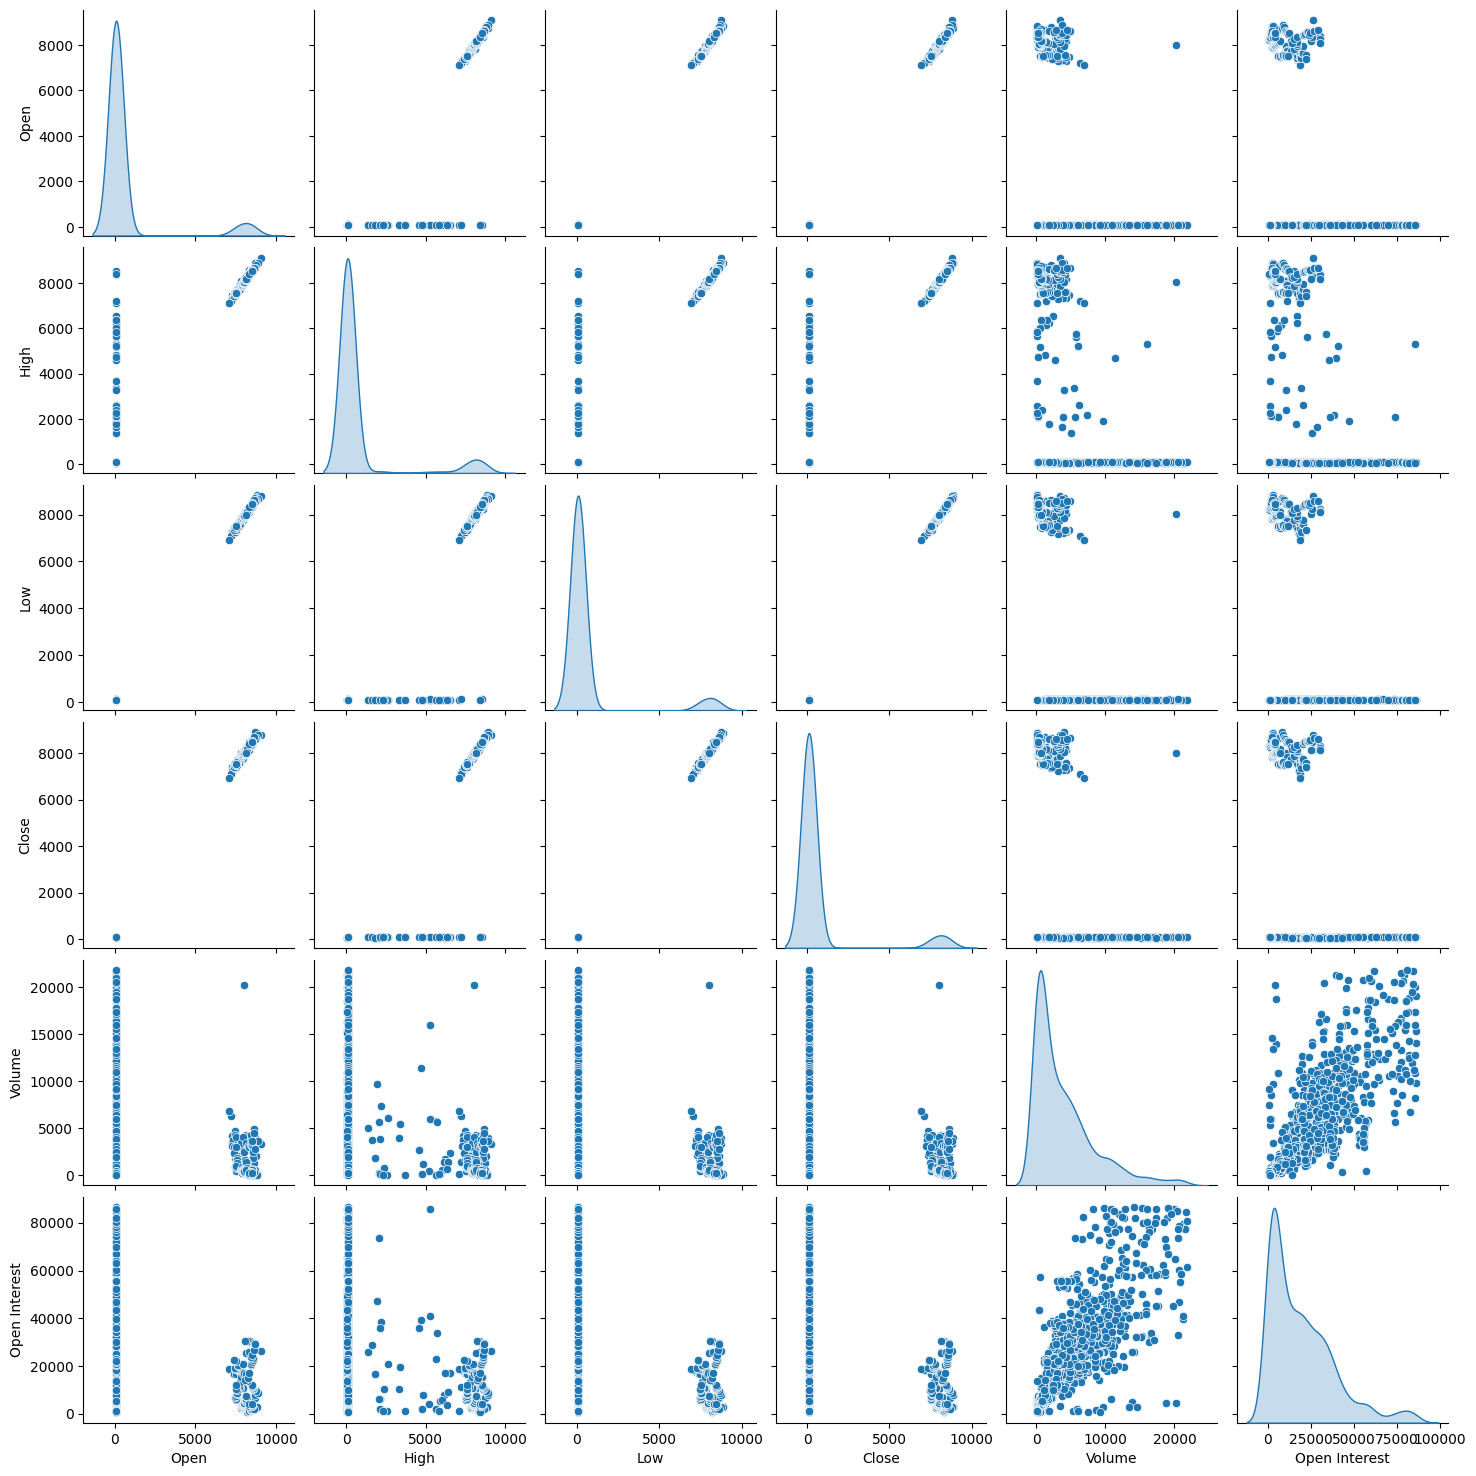

In [53]:
cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Open Interest']
sns.pairplot(daily_fixtures_only_logical_no_outliers[cols], diag_kind='kde')


**Conclusion:** `Volume` and `Open Interest` understandably seem to have a positive correlationship  

The following Correlation Matrix shows how numeric variables may correlate with each other

In [36]:
daily_fixtures_only_logical_no_outliers[['Timestamp', 'High', 'Low', 'Volume', "Open", "Close", 'Open Interest', ]].corr()

,Timestamp,High,Low,Volume,Open,Close,Open Interest
Timestamp,1.000000,-0.040386,-0.036011,0.087705,-0.036609,-0.036283,0.157797
High,-0.040386,1.000000,0.948443,-0.132009,0.948455,0.948447,-0.124704
Low,-0.036011,0.948443,1.000000,-0.126509,0.999971,0.999982,-0.122449
Volume,0.087705,-0.132009,-0.126509,1.000000,-0.126283,-0.126401,0.822622
Open,-0.036609,0.948455,0.999971,-0.126283,1.000000,0.999954,-0.122099
Close,-0.036283,0.948447,0.999982,-0.126401,0.999954,1.000000,-0.122254
Open Interest,0.157797,-0.124704,-0.122449,0.822622,-0.122099,-0.122254,1.000000


### Processing all the steps

The goal of the exercise above was to run this methodology on the entire dataset (containing all FUT contracts), however, outliers would naturally be ticker-dependent so it makes sense to process the above grouped by `Symbol`

##### The dataset can be "processed" via the helper method `process_input_df` to deal with nullity, identify and extract "logical" and "non-outlier" rows for a given ticker

In [92]:
# daily_futures[daily_futures.isna().any(axis=1)] # 1131


In [55]:
# Example for input dataframe
fut_processed = process_and_combined_input(df=daily_futures, just_flag=True)
fut_processed.to_csv("cleaned_flagged_input.csv", index=False)
fut_processed

Processed df for Symbol: FUT1
Processed df for Symbol: FUT2
Processed df for Symbol: FUT3
Processed df for Symbol: FUT4
Processed df for Symbol: FUT5
Processed df for Symbol: FUT6
Processed df for Symbol: FUT7
Processed df for Symbol: FUT8
Processed df for Symbol: FUT9
Processed df for Symbol: FUT10
Processed df for Symbol: FUT11
Processed df for Symbol: FUT12


,Symbol,Timestamp,Open,High,Low,Close,Volume,Open Interest,Date,is_logical,is_Open_outlier,is_High_outlier,is_Low_outlier,is_Close_outlier,is_Volume_outlier,is_Open Interest_outlier
0,FUT1,44929.0,8.742500e+01,8.797500e+01,8.527500e+01,8.460000e+01,2.791100e+04,6.958700e+04,2023-01-03,False,False,False,False,False,False,False
9,FUT1,44930.0,8.487500e+01,8.602500e+01,8.347500e+01,8.350000e+01,2.594000e+04,6.798900e+04,2023-01-04,True,False,False,False,False,False,False
18,FUT1,44931.0,8.355000e+01,8.397500e+01,8.160000e+01,8.267500e+01,2.905800e+04,6.266000e+04,2023-01-05,True,False,False,False,False,False,False
28,FUT1,44932.0,8.232500e+01,8.235000e+01,8.012500e+01,8.057500e+01,2.898800e+04,-4.315699e+06,2023-01-06,False,False,False,False,False,False,True
38,FUT1,44935.0,8.035000e+01,8.162500e+01,7.970000e+01,8.100000e+01,3.159300e+04,5.969200e+04,2023-01-09,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6345,FUT12,45812.0,-1.551712e+05,-4.118027e+03,-4.709729e+03,9.400000e+01,9.800000e+01,2.500147e+04,2025-06-04,False,False,False,False,False,False,True
6381,FUT12,45817.0,-5.433875e-07,-2.235757e+02,-1.000000e+20,-3.312516e+03,1.903921e-07,1.100000e+01,2025-06-09,False,False,False,True,False,False,False
6393,FUT12,45818.0,-1.000000e+15,-2.878332e-07,-2.617083e+05,8.150000e+01,3.925923e+11,1.100000e+01,2025-06-10,False,True,False,False,False,True,False
6637,FUT12,45852.0,7.350000e+01,3.079143e+03,1.000000e-08,-1.000000e+20,4.186383e+02,1.000000e-08,2025-07-14,False,False,False,False,True,False,False


In [56]:
fut_processed

,Symbol,Timestamp,Open,High,Low,Close,Volume,Open Interest,Date,is_logical,is_Open_outlier,is_High_outlier,is_Low_outlier,is_Close_outlier,is_Volume_outlier,is_Open Interest_outlier
0,FUT1,44929.0,8.742500e+01,8.797500e+01,8.527500e+01,8.460000e+01,2.791100e+04,6.958700e+04,2023-01-03,False,False,False,False,False,False,False
9,FUT1,44930.0,8.487500e+01,8.602500e+01,8.347500e+01,8.350000e+01,2.594000e+04,6.798900e+04,2023-01-04,True,False,False,False,False,False,False
18,FUT1,44931.0,8.355000e+01,8.397500e+01,8.160000e+01,8.267500e+01,2.905800e+04,6.266000e+04,2023-01-05,True,False,False,False,False,False,False
28,FUT1,44932.0,8.232500e+01,8.235000e+01,8.012500e+01,8.057500e+01,2.898800e+04,-4.315699e+06,2023-01-06,False,False,False,False,False,False,True
38,FUT1,44935.0,8.035000e+01,8.162500e+01,7.970000e+01,8.100000e+01,3.159300e+04,5.969200e+04,2023-01-09,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6345,FUT12,45812.0,-1.551712e+05,-4.118027e+03,-4.709729e+03,9.400000e+01,9.800000e+01,2.500147e+04,2025-06-04,False,False,False,False,False,False,True
6381,FUT12,45817.0,-5.433875e-07,-2.235757e+02,-1.000000e+20,-3.312516e+03,1.903921e-07,1.100000e+01,2025-06-09,False,False,False,True,False,False,False
6393,FUT12,45818.0,-1.000000e+15,-2.878332e-07,-2.617083e+05,8.150000e+01,3.925923e+11,1.100000e+01,2025-06-10,False,True,False,False,False,True,False
6637,FUT12,45852.0,7.350000e+01,3.079143e+03,1.000000e-08,-1.000000e+20,4.186383e+02,1.000000e-08,2025-07-14,False,False,False,False,True,False,False


### Logical "Fallacies" and "Outliers" by `Symbol`

In [69]:
logical_fallacies_by_symbol = (
    fut_processed.groupby("Symbol")
      .agg(
          total_entries=("is_logical", "size"),
          illogical_count=("is_logical", lambda x: (~x).sum())
      )
      .assign(illogical_pct=lambda d: 100 * d["illogical_count"] / d["total_entries"])
)
logical_fallacies_by_symbol.sort_values(by='illogical_pct')

,total_entries,illogical_count,illogical_pct
Symbol,,,
FUT5,647,275,42.503864
FUT6,646,275,42.569659
FUT8,624,268,42.948718
FUT1,644,277,43.012422
FUT2,646,279,43.188854
FUT3,646,302,46.749226
FUT4,646,305,47.213622
FUT9,592,281,47.466216
FUT7,575,287,49.913043


**Conclusion** All `Symbols`, with the exception of **FUT11** and **FUT12** (that have "illogical" percentages of about 75% and 100%), contain about 42%-57% illogical rows.

In [75]:
outlier_cols = [c for c in fut_processed.columns if c.startswith("is_") and c.endswith("_outlier")]
row_is_outlier = fut_processed[outlier_cols].any(axis=1)

outlier_summary = (
    fut_processed.groupby("Symbol")
      .agg(
          total_entries=("Symbol", "size"),
          outlier_count=("Symbol", lambda x: row_is_outlier.loc[x.index].sum())
      )
      .assign(outlier_pct=lambda d: 100 * d["outlier_count"] / d["total_entries"])
)
outlier_summary.sort_values(by='outlier_pct')

,total_entries,outlier_count,outlier_pct
Symbol,,,
FUT6,646,353,54.643963
FUT5,647,356,55.023184
FUT2,646,363,56.191950
FUT7,575,324,56.347826
FUT1,644,364,56.521739
FUT4,646,367,56.811146
FUT8,624,357,57.211538
FUT9,592,344,58.108108
FUT3,646,379,58.668731


**Conclusion** All `Symbols`demonstrate a high degree of "outliers" going by the 10-90 percentile acceptability rule. However, as mentioned previously, "tightening" the acceptability range would drastically reduce the dataset

In [79]:
row_is_illogical = ~fut_processed["is_logical"]
row_is_outlier = fut_processed[outlier_cols].any(axis=1)
row_is_both = row_is_illogical & row_is_outlier

combined_summary = (
    fut_processed.groupby("Symbol")
      .agg(
          total_entries=("Symbol", "size"),
          illogical_count=("Symbol", lambda x: row_is_illogical.loc[x.index].sum()),
          outlier_count=("Symbol", lambda x: row_is_outlier.loc[x.index].sum()),
          both_count=("Symbol", lambda x: row_is_both.loc[x.index].sum()),
      )
      .assign(
          illogical_pct=lambda d: 100 * d["illogical_count"] / d["total_entries"],
          outlier_pct=lambda d: 100 * d["outlier_count"] / d["total_entries"],
          both_pct=lambda d: 100 * d["both_count"] / d["total_entries"],
      )
)

combined_summary.sort_values(by='Symbol', key=lambda col: col.map(symbol_order) if col.name == 'Symbol' else col)

,total_entries,illogical_count,outlier_count,both_count,illogical_pct,outlier_pct,both_pct
Symbol,,,,,,,
FUT1,644,277,364,239,43.012422,56.521739,37.111801
FUT2,646,279,363,227,43.188854,56.191950,35.139319
FUT3,646,302,379,253,46.749226,58.668731,39.164087
FUT4,646,305,367,252,47.213622,56.811146,39.009288
FUT5,647,275,356,237,42.503864,55.023184,36.630603
FUT6,646,275,353,223,42.569659,54.643963,34.520124
FUT7,575,287,324,242,49.913043,56.347826,42.086957
FUT8,624,268,357,223,42.948718,57.211538,35.737179
FUT9,592,281,344,245,47.466216,58.108108,41.385135


**Future TODO**: Could outliers be a result of decimal errors? There is huge risk involved in scaling them with respect to central tendency stats.

# Ticker-wise Analysis: Understanding Gaps and Proposing Mitigating Strategies

##### Seeing how the data and distributions fared at a "macro" level, it is more reasonable to evaluate - at the ticker-level - to better undestand relationships


Ticker: FUT1

For column: Open
Summary Stats: 
count    188.000000
mean      85.379388
std        7.252485
min       72.600000
25%       80.000000
50%       84.887500
75%       89.431250
max      102.125000
Name: Open, dtype: float64


Missingness: 
0.0


Histogram:


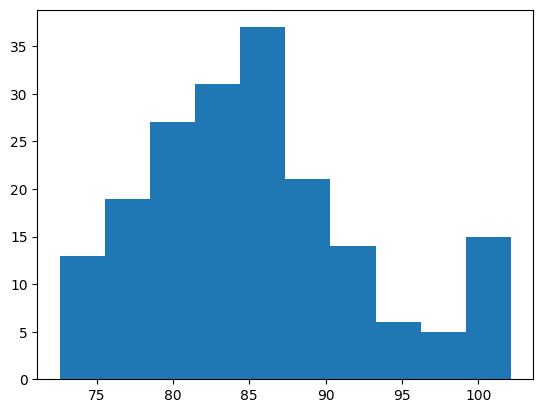




For column: High
Summary Stats: 
count    188.000000
mean      86.074601
std        7.277717
min       73.900000
25%       80.787500
50%       85.350000
75%       89.862500
max      102.700000
Name: High, dtype: float64


Missingness: 
0.0


Histogram:


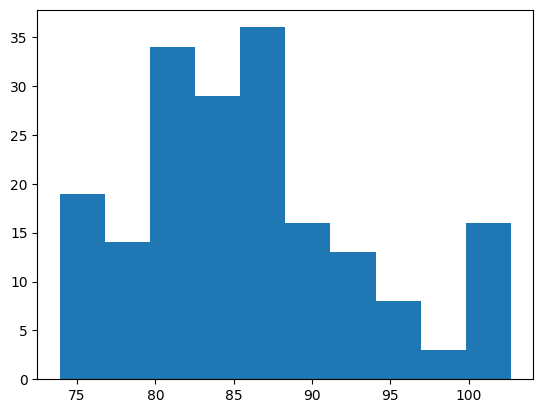




For column: Low
Summary Stats: 
count    188.000000
mean      84.777394
std        7.281494
min       72.500000
25%       79.375000
50%       83.937500
75%       88.987500
max      101.775000
Name: Low, dtype: float64


Missingness: 
0.0


Histogram:


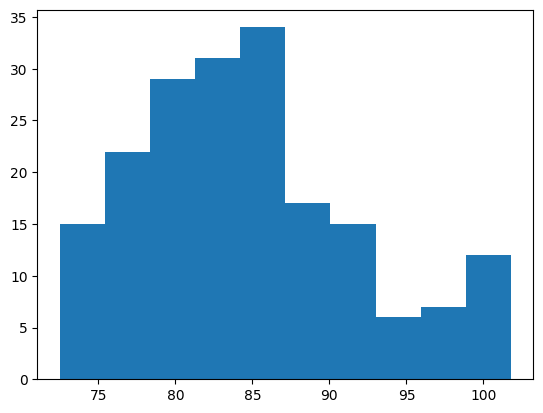




For column: Close
Summary Stats: 
count    188.000000
mean      85.403324
std        7.314532
min       73.500000
25%       79.975000
50%       84.550000
75%       89.437500
max      102.600000
Name: Close, dtype: float64


Missingness: 
0.0


Histogram:


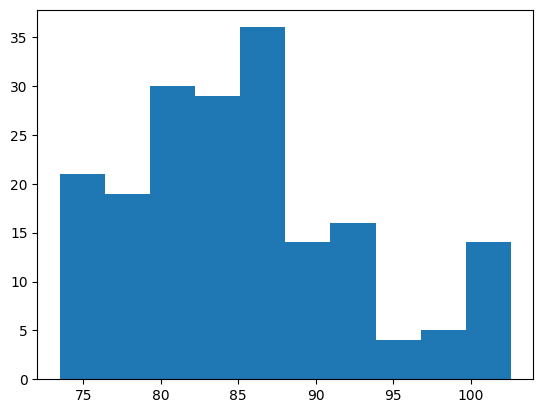




For column: Volume
Summary Stats: 
count      188.000000
mean     12580.148936
std       8204.263730
min        853.000000
25%       6098.250000
50%      10170.000000
75%      19051.000000
max      32213.000000
Name: Volume, dtype: float64


Missingness: 
0.0


Histogram:


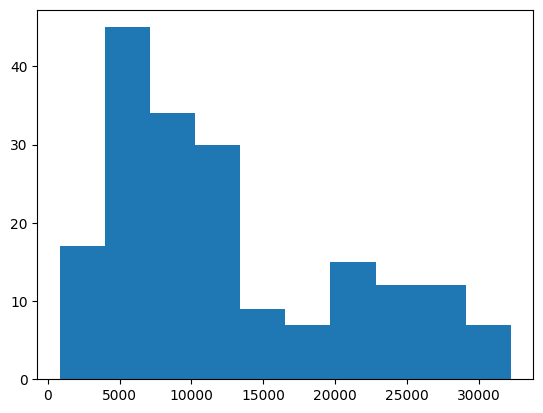




For column: Open Interest
Summary Stats: 
count       188.000000
mean      37337.122340
std       24303.616605
min        4268.000000
25%       19691.000000
50%       29503.000000
75%       46961.500000
max      102184.000000
Name: Open Interest, dtype: float64


Missingness: 
0.0


Histogram:


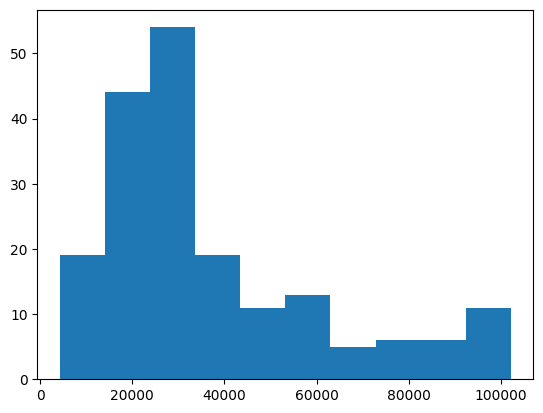




Ticker: FUT2

For column: Open
Summary Stats: 
count    171.000000
mean      86.441667
std        8.183064
min       72.625000
25%       80.850000
50%       86.100000
75%       90.712500
max      107.425000
Name: Open, dtype: float64


Missingness: 
0.0


Histogram:


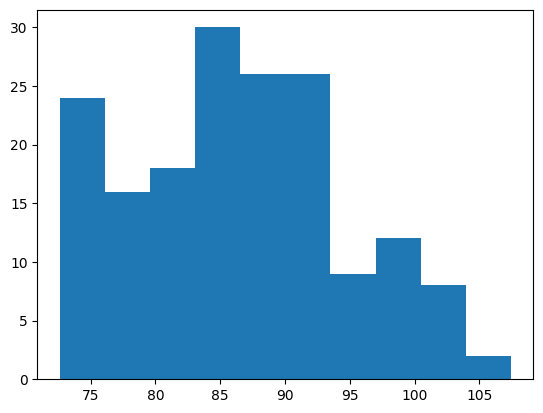




For column: High
Summary Stats: 
count     171.000000
mean      105.259418
std       172.935251
min        73.950000
25%        81.700000
50%        87.450000
75%        91.800000
max      2085.880488
Name: High, dtype: float64


Missingness: 
0.0


Histogram:


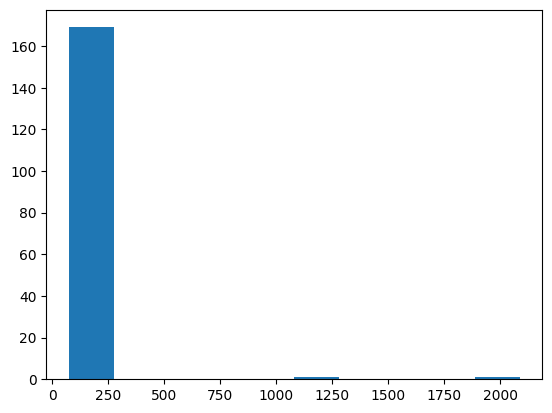




For column: Low
Summary Stats: 
count    171.000000
mean      85.518275
std        8.068975
min       72.425000
25%       80.125000
50%       85.625000
75%       90.075000
max      105.700000
Name: Low, dtype: float64


Missingness: 
0.0


Histogram:


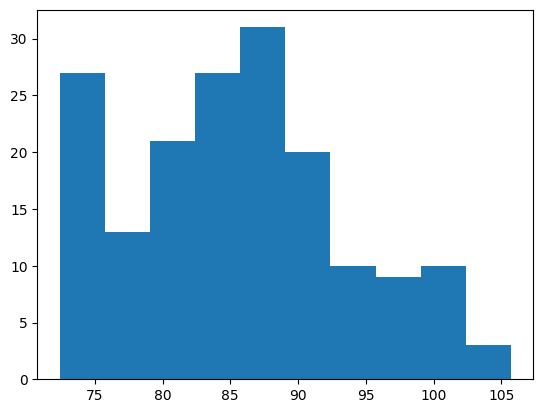




For column: Close
Summary Stats: 
count    171.000000
mean      86.449854
std        8.046798
min       73.375000
25%       81.100000
50%       86.350000
75%       90.750000
max      106.050000
Name: Close, dtype: float64


Missingness: 
0.0


Histogram:


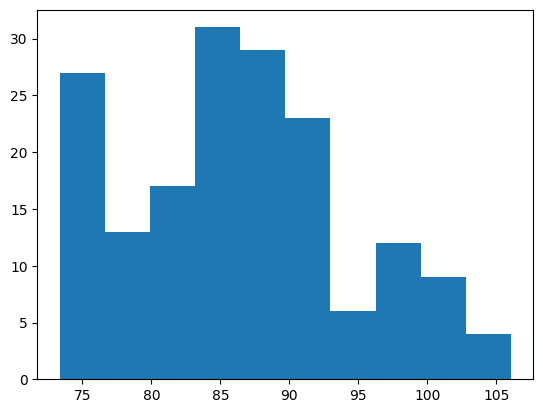




For column: Volume
Summary Stats: 
count      171.000000
mean     16613.934162
std       9259.272455
min        277.000000
25%      12157.000000
50%      18716.000000
75%      23250.000000
max      31973.000000
Name: Volume, dtype: float64


Missingness: 
0.0


Histogram:


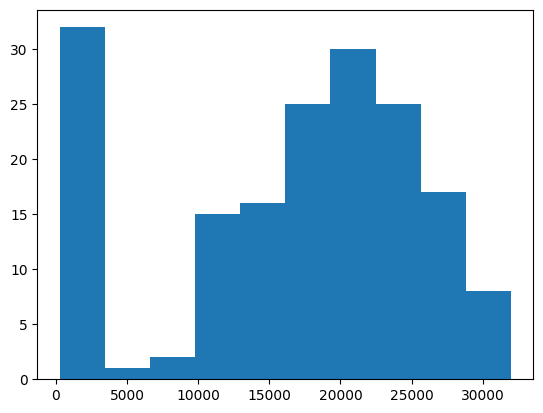




For column: Open Interest
Summary Stats: 
count       171.000000
mean      71563.892293
std       36148.848705
min        4148.000000
25%       56682.500000
50%       84955.000000
75%       96802.000000
max      122955.000000
Name: Open Interest, dtype: float64


Missingness: 
0.0


Histogram:


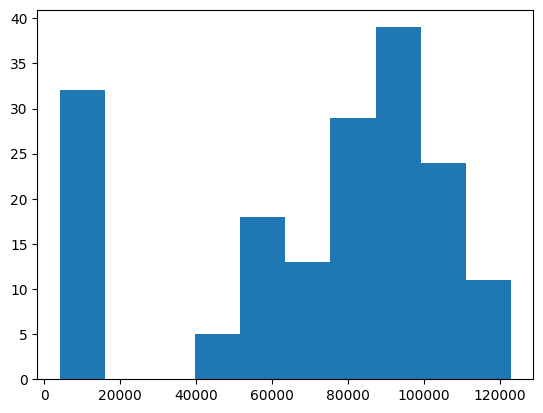




Ticker: FUT3

For column: Open
Summary Stats: 
count      168.000000
mean       845.131399
std       6894.507181
min         76.350000
25%         81.706250
50%         90.837500
75%         99.450000
max      64425.000000
Name: Open, dtype: float64


Missingness: 
0.0


Histogram:


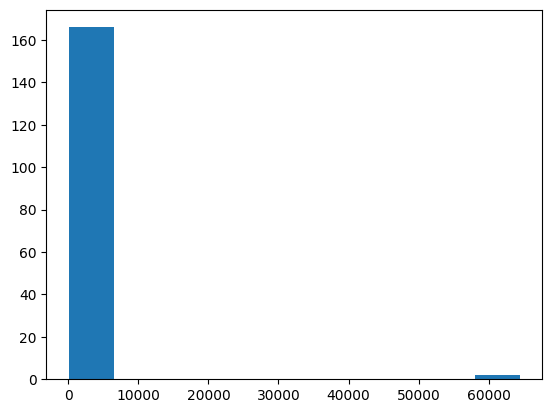




For column: High
Summary Stats: 
count      168.000000
mean       980.170624
std       7107.969387
min         77.225000
25%         82.768750
50%         92.462500
75%        101.006250
max      65925.000000
Name: High, dtype: float64


Missingness: 
0.0


Histogram:


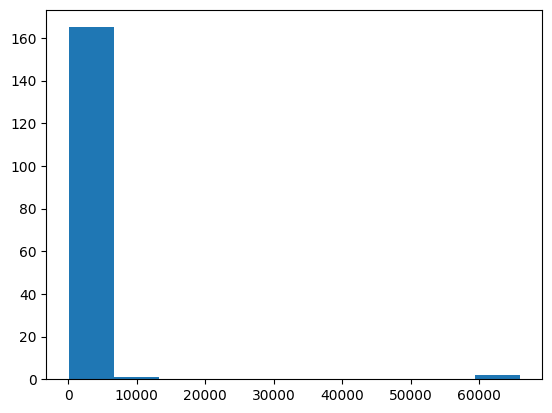




For column: Low
Summary Stats: 
count      168.000000
mean       843.751339
std       6889.073586
min         75.675000
25%         80.562500
50%         90.000000
75%         98.675000
max      64325.000000
Name: Low, dtype: float64


Missingness: 
0.0


Histogram:


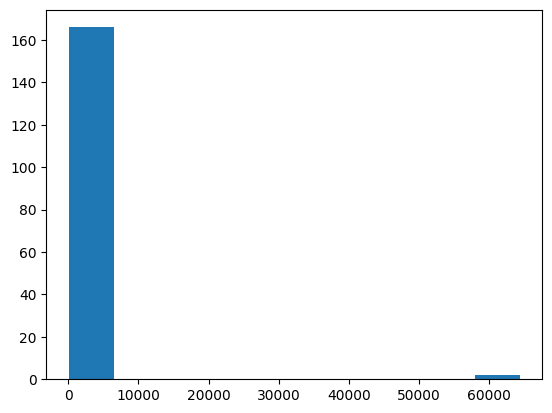




For column: Close
Summary Stats: 
count      168.000000
mean       863.028720
std       7057.396818
min         76.175000
25%         81.631250
50%         90.925000
75%         99.556250
max      65750.000000
Name: Close, dtype: float64


Missingness: 
0.0


Histogram:


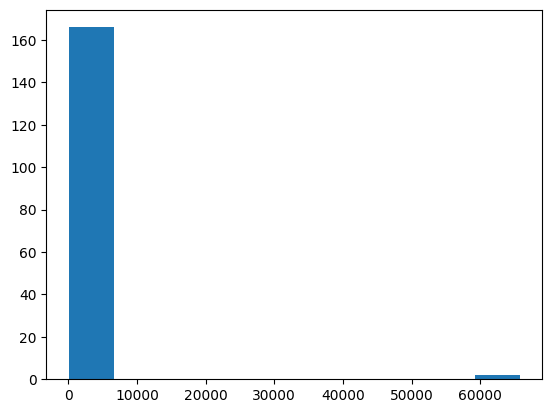




For column: Volume
Summary Stats: 
count      168.000000
mean     10825.811819
std       6677.136549
min        138.000000
25%       6460.750000
50%      10334.500000
75%      15441.250000
max      25458.000000
Name: Volume, dtype: float64


Missingness: 
0.0


Histogram:


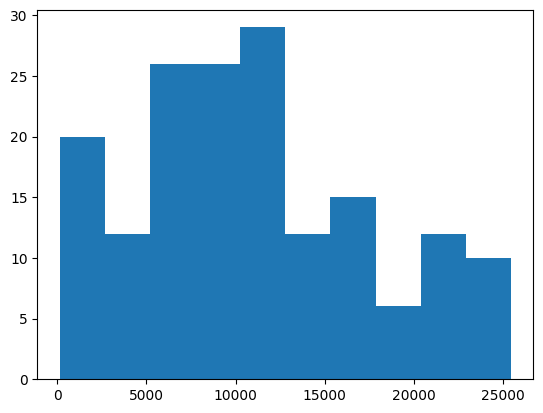




For column: Open Interest
Summary Stats: 
count      168.000000
mean     50585.184524
std      25755.451791
min       1932.000000
25%      36639.000000
50%      48113.500000
75%      70185.500000
max      93683.000000
Name: Open Interest, dtype: float64


Missingness: 
0.0


Histogram:


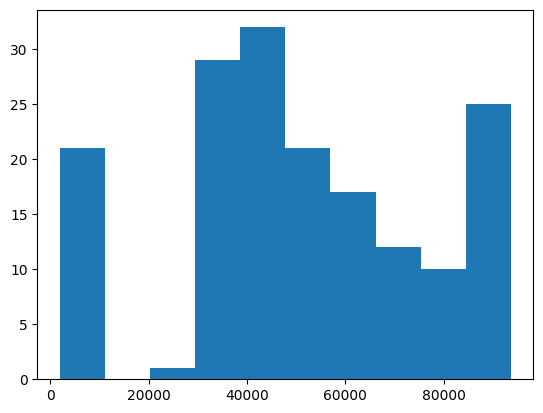




Ticker: FUT4

For column: Open
Summary Stats: 
count     174.000000
mean      690.078017
std      2313.740000
min        75.725000
25%        82.262500
50%        91.987500
75%       102.618750
max      9875.000000
Name: Open, dtype: float64


Missingness: 
0.0


Histogram:


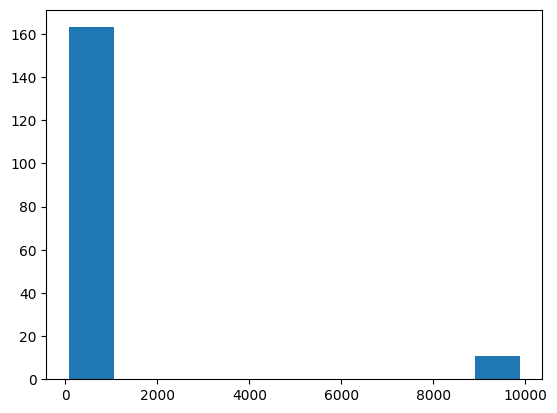




For column: High
Summary Stats: 
count     174.000000
mean      823.161120
std      2454.756045
min        77.400000
25%        83.256250
50%        92.787500
75%       103.525000
max      9932.500000
Name: High, dtype: float64


Missingness: 
0.0


Histogram:


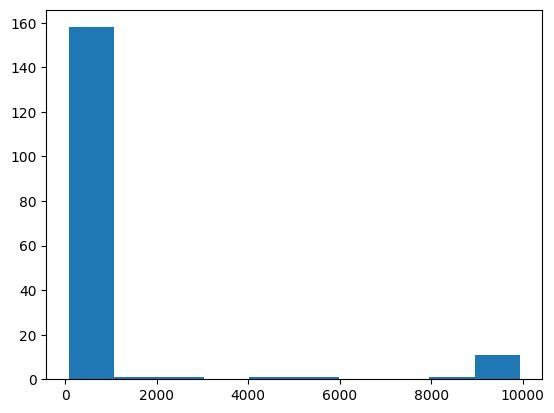




For column: Low
Summary Stats: 
count     174.000000
mean      683.222126
std      2289.801899
min        75.500000
25%        81.625000
50%        91.112500
75%       101.337500
max      9797.500000
Name: Low, dtype: float64


Missingness: 
0.0


Histogram:


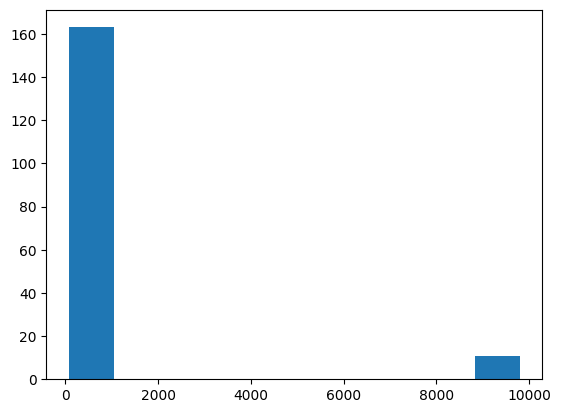




For column: Close
Summary Stats: 
count     174.000000
mean      690.392529
std      2314.537211
min        76.275000
25%        82.400000
50%        91.675000
75%       102.056250
max      9907.500000
Name: Close, dtype: float64


Missingness: 
0.0


Histogram:


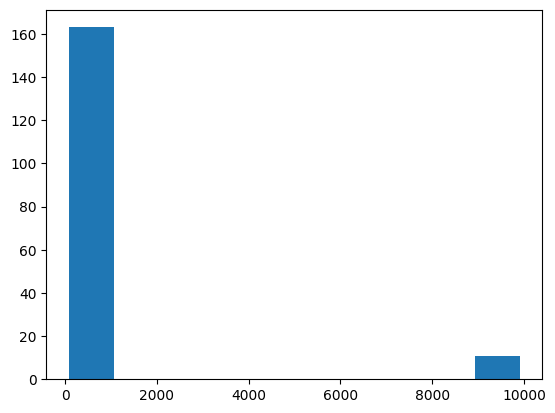




For column: Volume
Summary Stats: 
count      174.000000
mean      5977.282075
std       2864.323520
min         88.000000
25%       4157.750000
50%       5790.500000
75%       7833.750000
max      12702.000000
Name: Volume, dtype: float64


Missingness: 
0.0


Histogram:


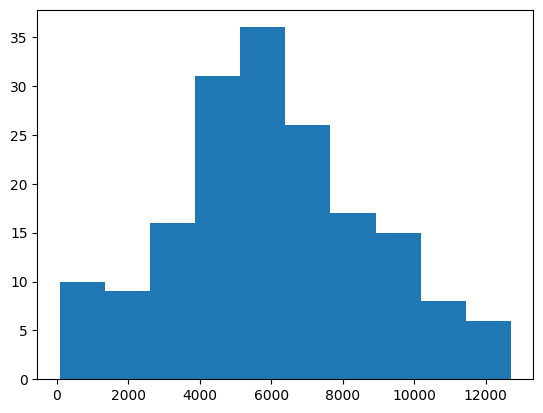




For column: Open Interest
Summary Stats: 
count      174.000000
mean     30163.591954
std      11792.290603
min       3206.000000
25%      23046.000000
50%      30064.500000
75%      37237.000000
max      57969.000000
Name: Open Interest, dtype: float64


Missingness: 
0.0


Histogram:


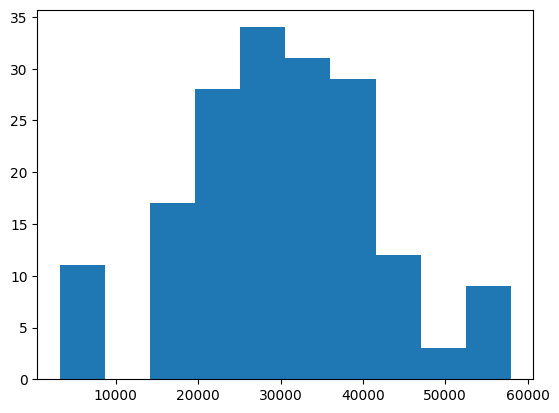




Ticker: FUT5

For column: Open
Summary Stats: 
count     201.000000
mean     1036.853980
std      2504.452383
min        80.375000
25%        93.025000
50%        99.125000
75%       104.525000
max      8430.000000
Name: Open, dtype: float64


Missingness: 
0.0


Histogram:


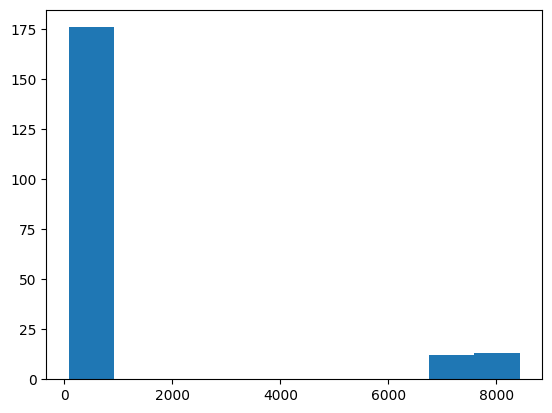




For column: High
Summary Stats: 
count     201.000000
mean     1206.850046
std      2619.776456
min        81.650000
25%        93.725000
50%       100.575000
75%       105.350000
max      8452.500000
Name: High, dtype: float64


Missingness: 
0.0


Histogram:


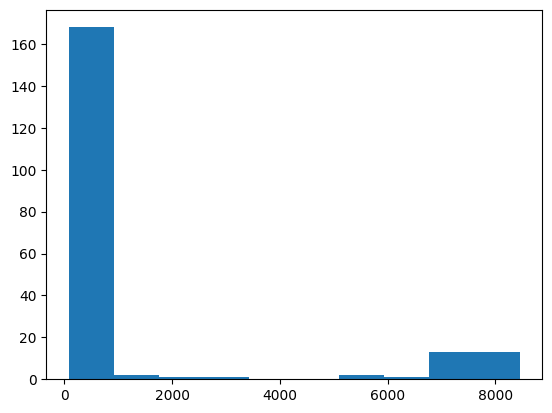




For column: Low
Summary Stats: 
count     201.000000
mean     1027.819900
std      2482.915244
min        79.650000
25%        92.450000
50%        98.900000
75%       103.475000
max      8367.500000
Name: Low, dtype: float64


Missingness: 
0.0


Histogram:


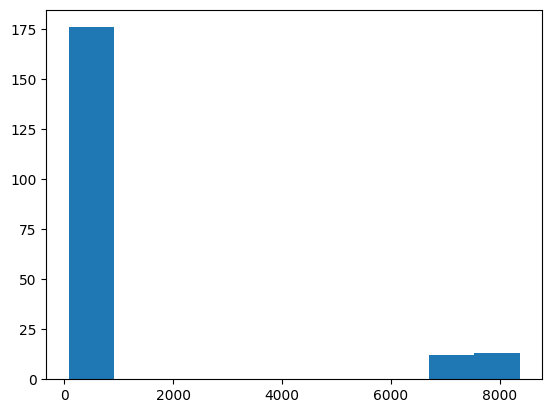




For column: Close
Summary Stats: 
count     201.000000
mean     1035.656343
std      2501.769611
min        80.275000
25%        92.875000
50%        99.450000
75%       104.100000
max      8410.000000
Name: Close, dtype: float64


Missingness: 
0.0


Histogram:


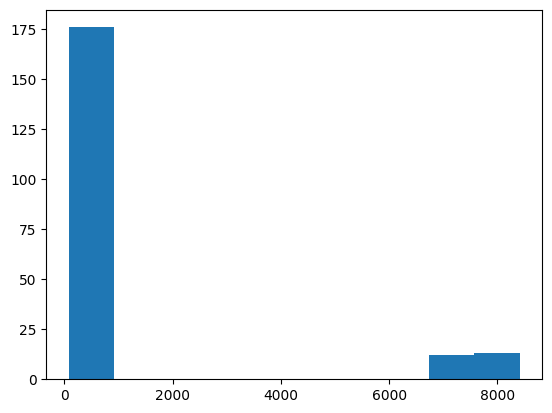




For column: Volume
Summary Stats: 
count     201.000000
mean     4030.671642
std      1908.034798
min        47.000000
25%      2489.000000
50%      3993.000000
75%      5594.000000
max      7917.000000
Name: Volume, dtype: float64


Missingness: 
0.0


Histogram:


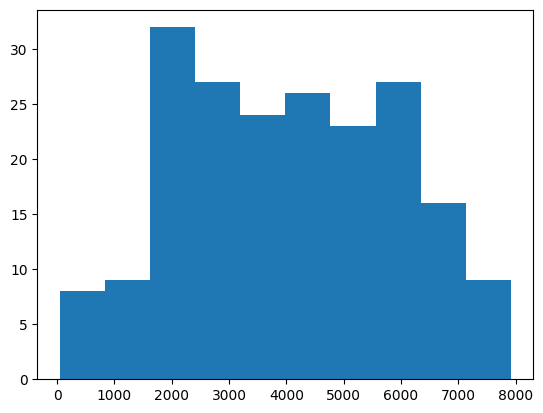




For column: Open Interest
Summary Stats: 
count      201.000000
mean     22284.348259
std       9464.663266
min       1100.000000
25%      16033.000000
50%      21658.000000
75%      29635.000000
max      43168.000000
Name: Open Interest, dtype: float64


Missingness: 
0.0


Histogram:


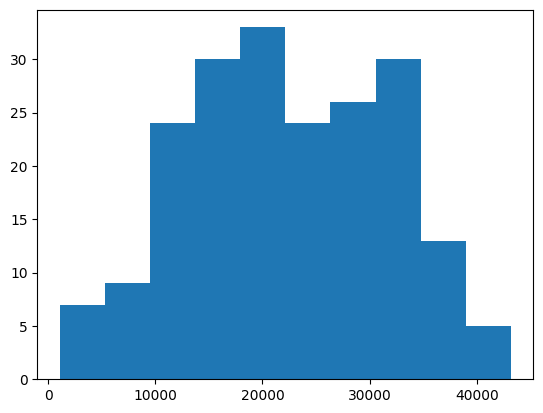




Ticker: FUT6

For column: Open
Summary Stats: 
count     203.000000
mean      858.881527
std      2322.300750
min        79.475000
25%        90.112500
50%        95.000000
75%       100.500000
max      8307.500000
Name: Open, dtype: float64


Missingness: 
0.0


Histogram:


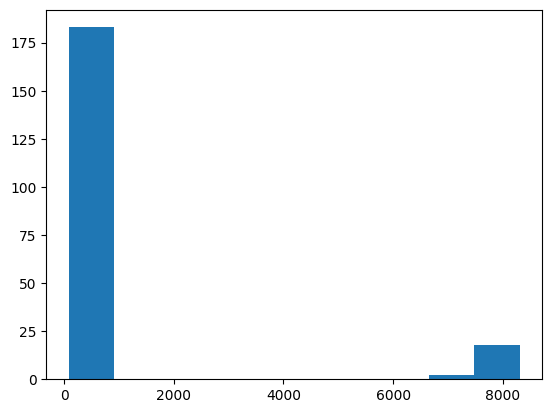




For column: High
Summary Stats: 
count     203.000000
mean      888.036374
std      2355.778701
min        79.525000
25%        90.812500
50%        95.650000
75%       101.162500
max      8335.000000
Name: High, dtype: float64


Missingness: 
0.0


Histogram:


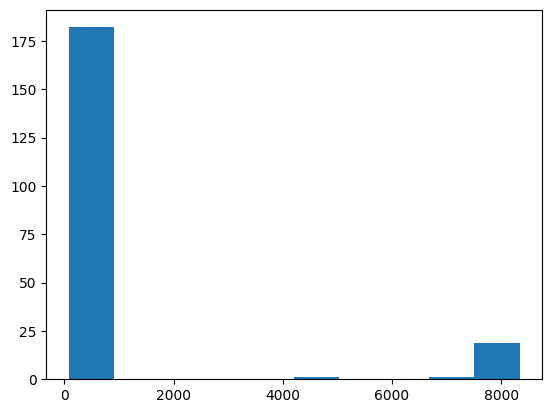




For column: Low
Summary Stats: 
count     203.000000
mean      848.462685
std      2292.685202
min        77.950000
25%        89.162500
50%        94.600000
75%        99.700000
max      8177.500000
Name: Low, dtype: float64


Missingness: 
0.0


Histogram:


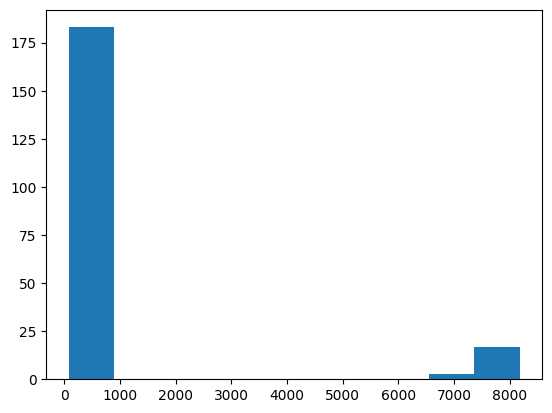




For column: Close
Summary Stats: 
count     203.000000
mean      857.283251
std      2317.563126
min        78.300000
25%        89.912500
50%        94.975000
75%       100.537500
max      8210.000000
Name: Close, dtype: float64


Missingness: 
0.0


Histogram:


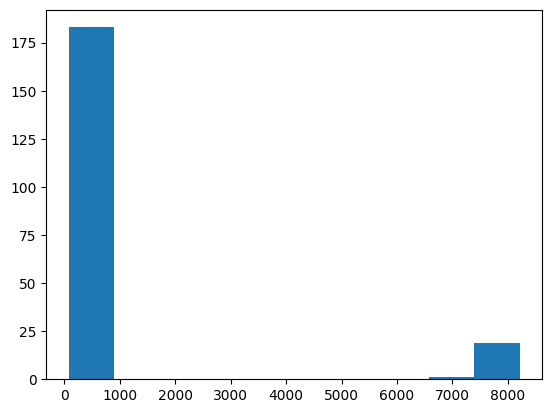




For column: Volume
Summary Stats: 
count     203.000000
mean     2867.458128
std      1341.438024
min       195.000000
25%      1809.000000
50%      2581.000000
75%      4030.500000
max      5582.000000
Name: Volume, dtype: float64


Missingness: 
0.0


Histogram:


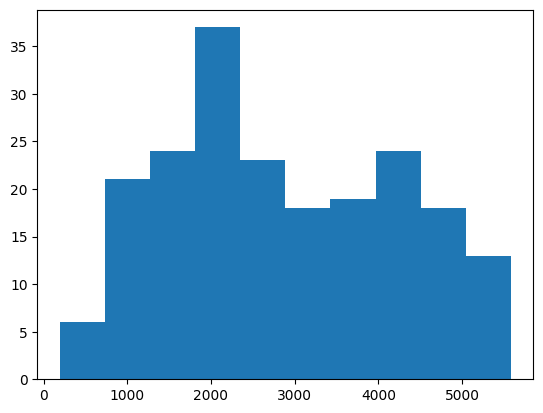




For column: Open Interest
Summary Stats: 
count      203.000000
mean     18601.645320
std       7346.356823
min        972.000000
25%      12972.500000
50%      18442.000000
75%      23036.000000
max      37489.000000
Name: Open Interest, dtype: float64


Missingness: 
0.0


Histogram:


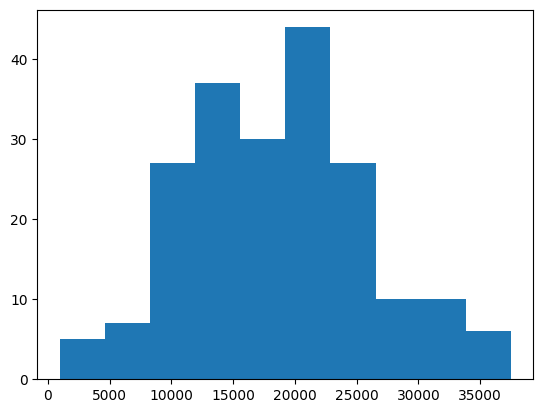




Ticker: FUT7

For column: Open
Summary Stats: 
count     153.000000
mean      519.719118
std      1850.969983
min        77.200000
25%        81.925000
50%        85.375000
75%        92.200000
max      8565.000000
Name: Open, dtype: float64


Missingness: 
0.0


Histogram:


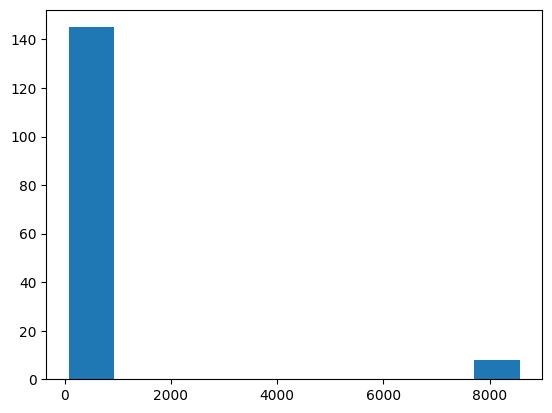




For column: High
Summary Stats: 
count     153.000000
mean      618.267087
std      1976.458626
min        77.575000
25%        82.400000
50%        86.125000
75%        92.925000
max      8577.500000
Name: High, dtype: float64


Missingness: 
0.0


Histogram:


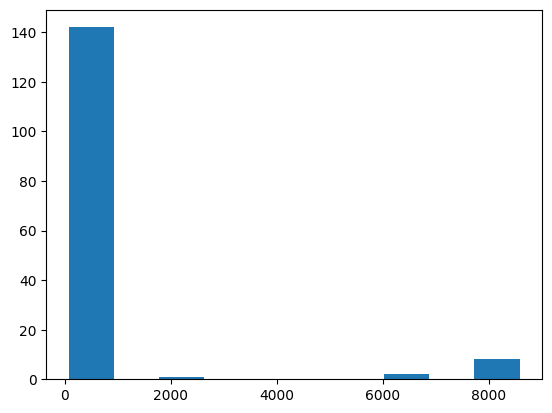




For column: Low
Summary Stats: 
count     153.000000
mean      516.689216
std      1840.380020
min        76.700000
25%        81.225000
50%        84.975000
75%        91.450000
max      8512.500000
Name: Low, dtype: float64


Missingness: 
0.0


Histogram:


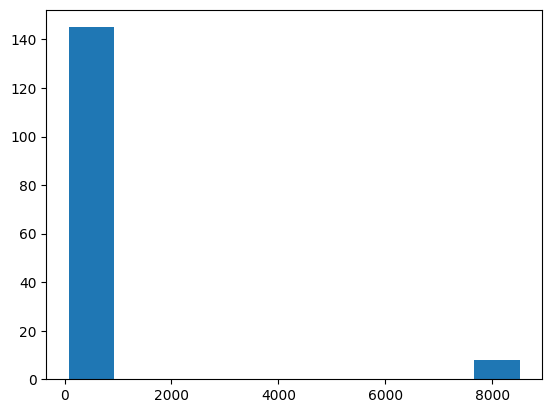




For column: Close
Summary Stats: 
count     153.000000
mean      520.024020
std      1852.059421
min        77.400000
25%        81.775000
50%        85.525000
75%        92.350000
max      8535.000000
Name: Close, dtype: float64


Missingness: 
0.0


Histogram:


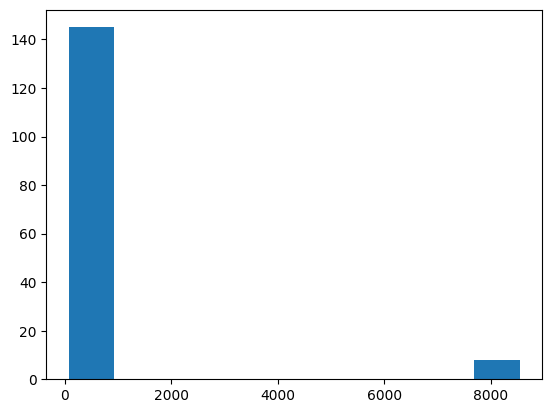




For column: Volume
Summary Stats: 
count     153.000000
mean     1388.803922
std       831.964994
min       164.000000
25%       719.000000
50%      1267.000000
75%      1964.000000
max      3585.000000
Name: Volume, dtype: float64


Missingness: 
0.0


Histogram:


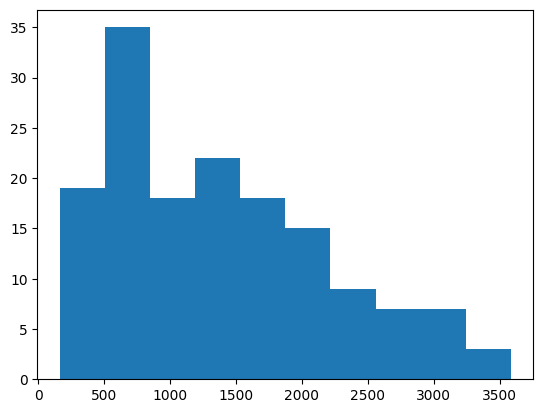




For column: Open Interest
Summary Stats: 
count      153.000000
mean      9943.849673
std       5305.673140
min        882.000000
25%       5688.000000
50%       8717.000000
75%      13652.000000
max      23420.000000
Name: Open Interest, dtype: float64


Missingness: 
0.0


Histogram:


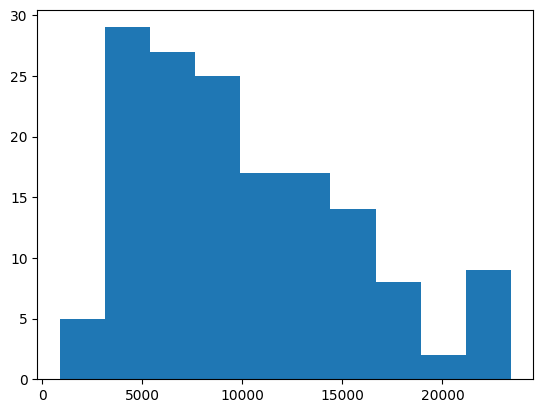




Ticker: FUT8

For column: Open
Summary Stats: 
count     185.000000
mean     2138.103649
std      3588.022686
min        76.225000
25%        83.225000
50%        91.450000
75%        98.550000
max      9610.000000
Name: Open, dtype: float64


Missingness: 
0.0


Histogram:


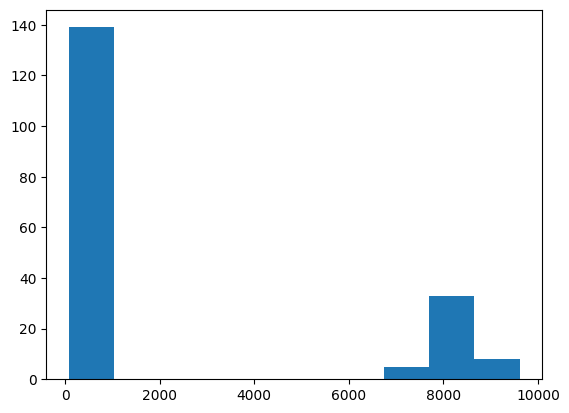




For column: High
Summary Stats: 
count     185.000000
mean     2258.178983
std      3630.201086
min        76.375000
25%        83.850000
50%        91.875000
75%      7515.000000
max      9655.000000
Name: High, dtype: float64


Missingness: 
0.0


Histogram:


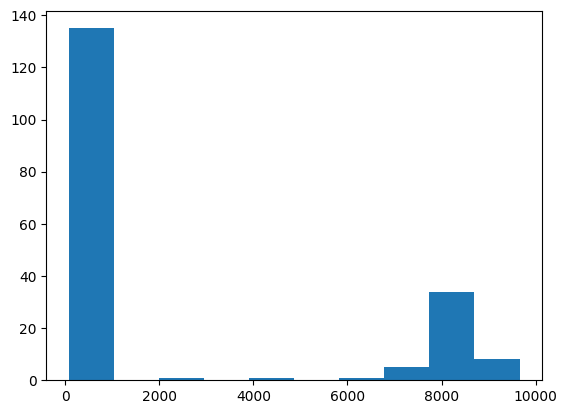




For column: Low
Summary Stats: 
count     185.000000
mean     2124.481757
std      3564.360918
min        75.800000
25%        82.525000
50%        90.750000
75%        97.725000
max      9510.000000
Name: Low, dtype: float64


Missingness: 
0.0


Histogram:


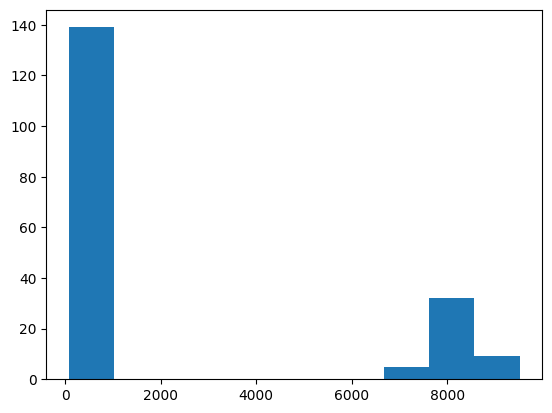




For column: Close
Summary Stats: 
count     185.000000
mean     2133.087568
std      3578.398195
min        76.275000
25%        83.025000
50%        91.075000
75%        98.075000
max      9592.500000
Name: Close, dtype: float64


Missingness: 
0.0


Histogram:


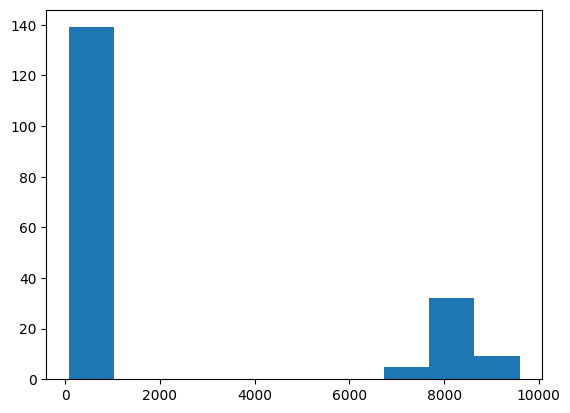




For column: Volume
Summary Stats: 
count     185.000000
mean      496.810811
std       283.941497
min        73.000000
25%       249.000000
50%       441.000000
75%       722.000000
max      1227.000000
Name: Volume, dtype: float64


Missingness: 
0.0


Histogram:


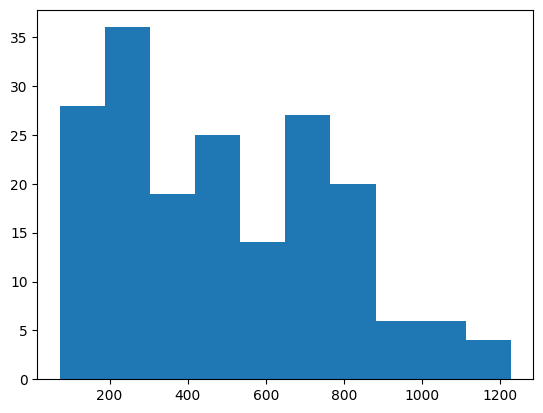




For column: Open Interest
Summary Stats: 
count     185.000000
mean     4190.810811
std      2051.401555
min       875.000000
25%      2503.000000
50%      3826.000000
75%      5908.000000
max      8706.000000
Name: Open Interest, dtype: float64


Missingness: 
0.0


Histogram:


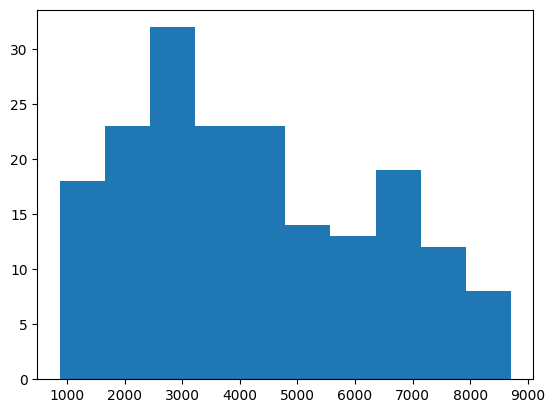




Ticker: FUT9

For column: Open
Summary Stats: 
count      158.000000
mean      9241.773576
std      24868.912373
min         77.600000
25%         83.018750
50%         90.087500
75%         95.043750
max      82600.000000
Name: Open, dtype: float64


Missingness: 
0.0


Histogram:


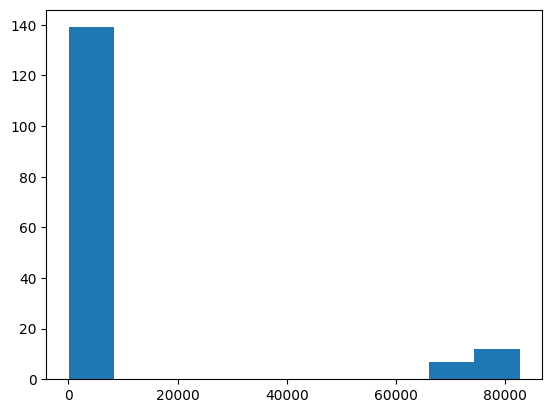




For column: High
Summary Stats: 
count      158.000000
mean      9432.398233
std      24905.038299
min         77.825000
25%         83.693750
50%         90.800000
75%         95.487500
max      82950.000000
Name: High, dtype: float64


Missingness: 
0.0


Histogram:


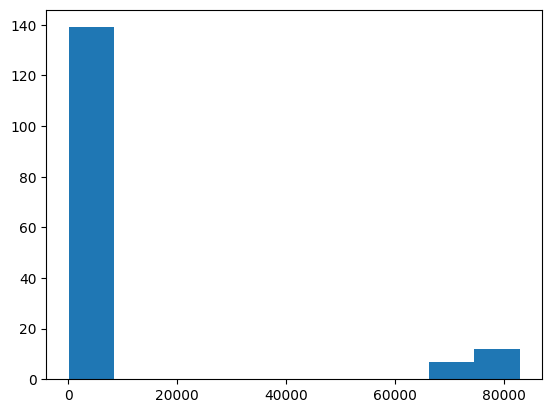




For column: Low
Summary Stats: 
count      158.000000
mean      9226.776741
std      24828.883372
min         76.975000
25%         82.556250
50%         89.650000
75%         94.743750
max      82575.000000
Name: Low, dtype: float64


Missingness: 
0.0


Histogram:


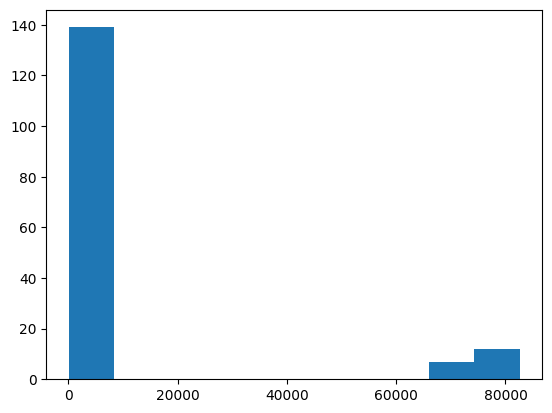




For column: Close
Summary Stats: 
count      158.000000
mean      9259.423734
std      24915.308242
min         77.425000
25%         82.925000
50%         90.400000
75%         95.081250
max      82950.000000
Name: Close, dtype: float64


Missingness: 
0.0


Histogram:


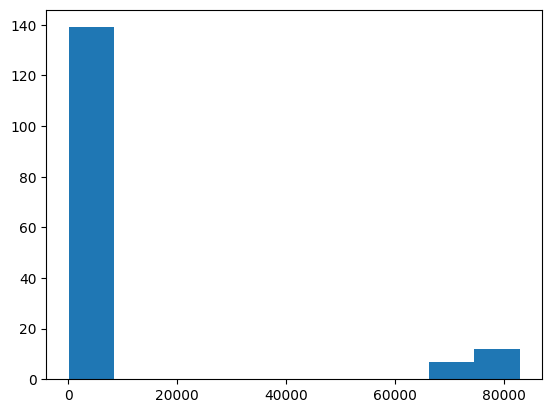




For column: Volume
Summary Stats: 
count    158.000000
mean     123.018987
std       81.613933
min       23.000000
25%       62.000000
50%      100.000000
75%      163.750000
max      428.000000
Name: Volume, dtype: float64


Missingness: 
0.0


Histogram:


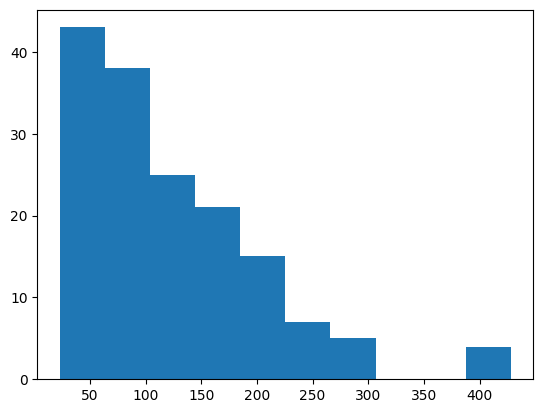




For column: Open Interest
Summary Stats: 
count     158.000000
mean     1271.417722
std       552.497805
min       418.000000
25%       799.000000
50%      1092.500000
75%      1756.750000
max      2605.000000
Name: Open Interest, dtype: float64


Missingness: 
0.0


Histogram:


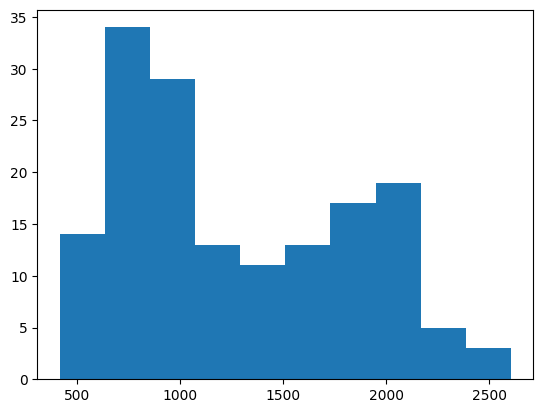




Ticker: FUT10

For column: Open
Summary Stats: 
count    81.000000
mean     86.125617
std       7.410681
min      75.500000
25%      80.025000
50%      83.675000
75%      93.650000
max      96.150000
Name: Open, dtype: float64


Missingness: 
0.0


Histogram:


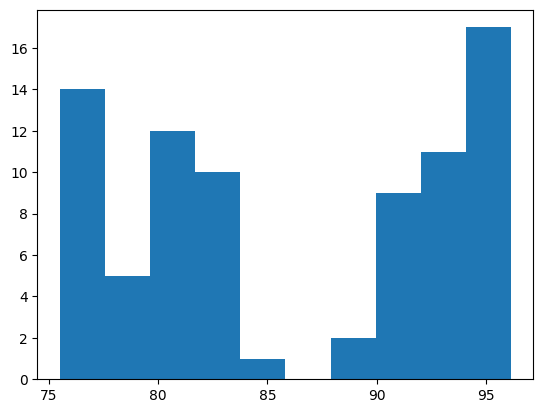




For column: High
Summary Stats: 
count    81.000000
mean     86.372531
std       7.396006
min      75.750000
25%      80.300000
50%      83.825000
75%      93.800000
max      96.300000
Name: High, dtype: float64


Missingness: 
0.0


Histogram:


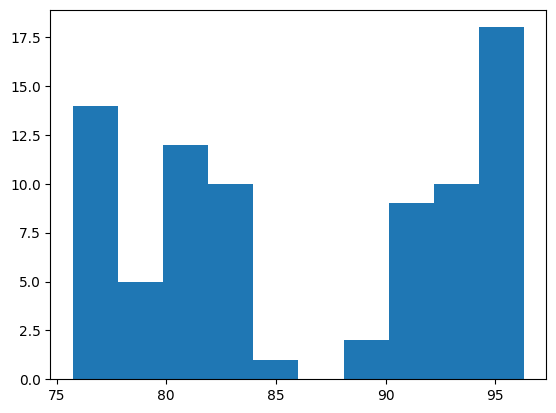




For column: Low
Summary Stats: 
count    81.000000
mean     85.929938
std       7.443374
min      75.275000
25%      80.000000
50%      83.675000
75%      93.500000
max      96.125000
Name: Low, dtype: float64


Missingness: 
0.0


Histogram:


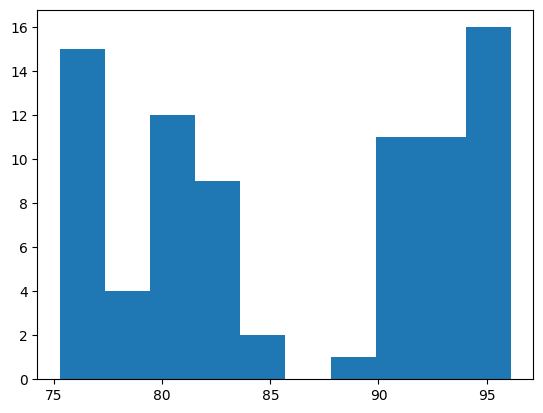




For column: Close
Summary Stats: 
count    81.000000
mean     86.173765
std       7.433663
min      75.600000
25%      80.025000
50%      83.825000
75%      93.500000
max      96.300000
Name: Close, dtype: float64


Missingness: 
0.0


Histogram:


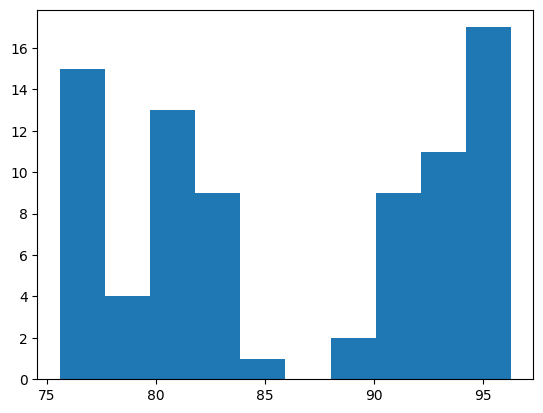




For column: Volume
Summary Stats: 
count     81.000000
mean      35.382716
std       31.045760
min        2.000000
25%       10.000000
50%       27.000000
75%       48.000000
max      145.000000
Name: Volume, dtype: float64


Missingness: 
0.0


Histogram:


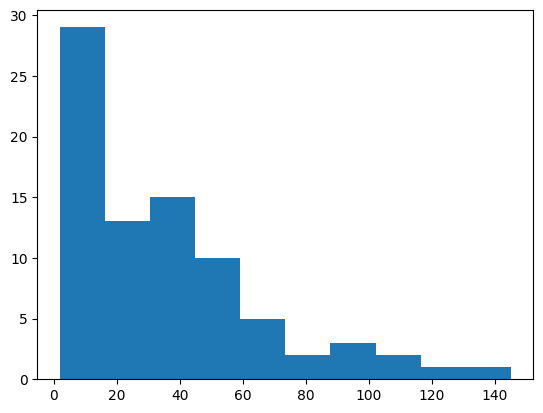




For column: Open Interest
Summary Stats: 
count      81.000000
mean      347.135802
std       219.439499
min        33.000000
25%       213.000000
50%       279.000000
75%       464.000000
max      1017.000000
Name: Open Interest, dtype: float64


Missingness: 
0.0


Histogram:


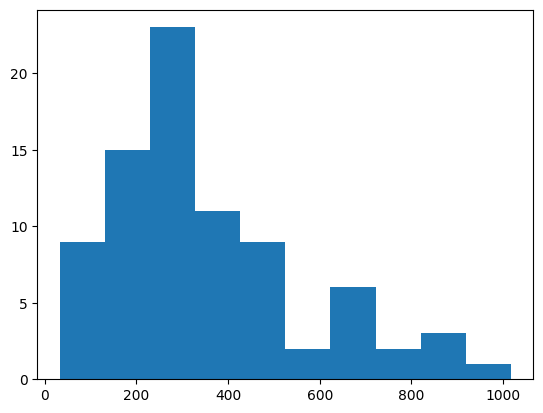




Ticker: FUT11

For column: Open
Summary Stats: 
count    18.000000
mean     91.611111
std       6.053841
min      80.125000
25%      90.593750
50%      93.587500
75%      94.887500
max      99.750000
Name: Open, dtype: float64


Missingness: 
0.0


Histogram:


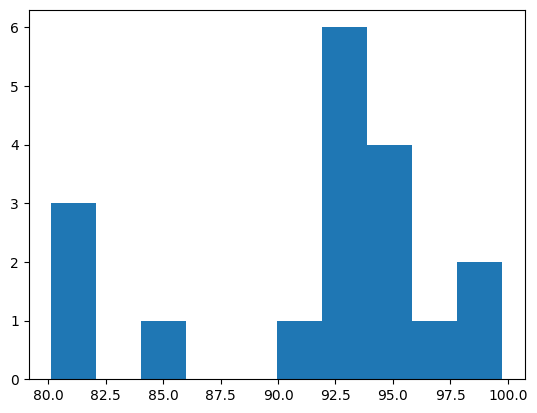




For column: High
Summary Stats: 
count     18.000000
mean      91.729167
std        6.049600
min       80.350000
25%       90.631250
50%       93.875000
75%       94.887500
max      100.100000
Name: High, dtype: float64


Missingness: 
0.0


Histogram:


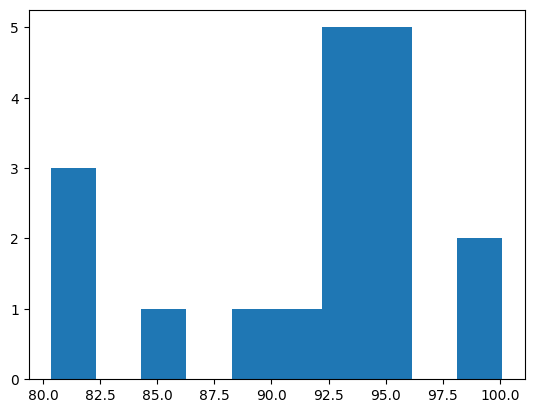




For column: Low
Summary Stats: 
count    18.000000
mean     91.398611
std       6.011548
min      79.500000
25%      90.543750
50%      93.500000
75%      94.312500
max      99.150000
Name: Low, dtype: float64


Missingness: 
0.0


Histogram:


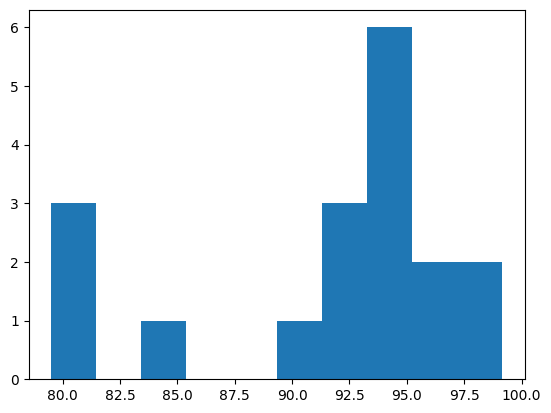




For column: Close
Summary Stats: 
count    18.000000
mean     91.512500
std       6.052492
min      79.500000
25%      90.543750
50%      93.662500
75%      94.650000
max      99.150000
Name: Close, dtype: float64


Missingness: 
0.0


Histogram:


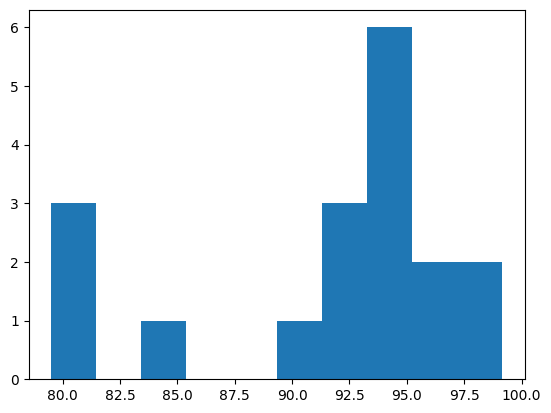




For column: Volume
Summary Stats: 
count    18.000000
mean     20.944444
std      18.299702
min       2.000000
25%       5.250000
50%      18.000000
75%      32.500000
max      71.000000
Name: Volume, dtype: float64


Missingness: 
0.0


Histogram:


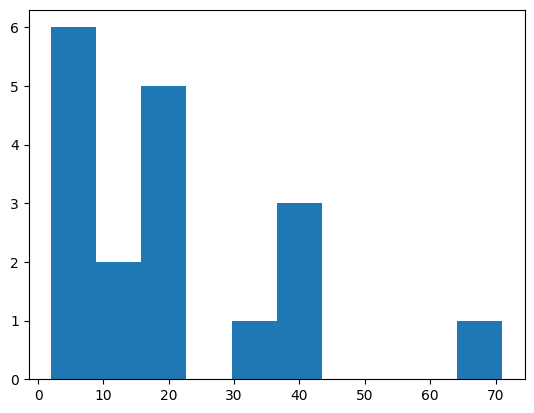




For column: Open Interest
Summary Stats: 
count     18.000000
mean     117.888889
std      145.991897
min       17.000000
25%       33.500000
50%       80.000000
75%      119.500000
max      537.000000
Name: Open Interest, dtype: float64


Missingness: 
0.0


Histogram:


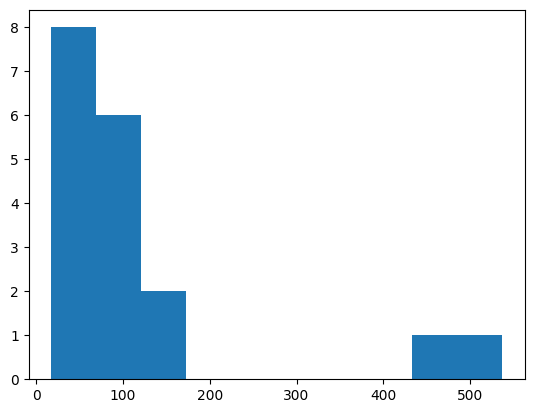




Ticker: FUT12

For column: Open
Summary Stats: 
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Open, dtype: float64


Missingness: 
0.0


Histogram:


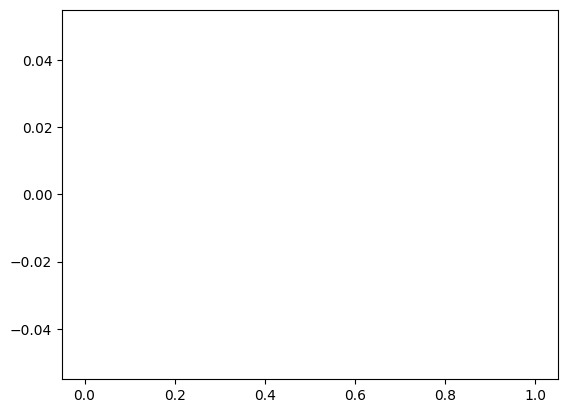




For column: High
Summary Stats: 
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: High, dtype: float64


Missingness: 
0.0


Histogram:


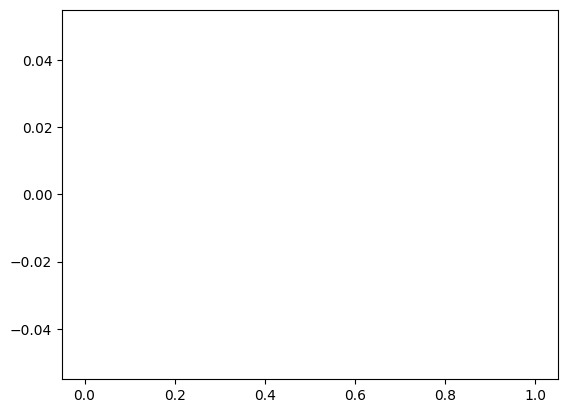




For column: Low
Summary Stats: 
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Low, dtype: float64


Missingness: 
0.0


Histogram:


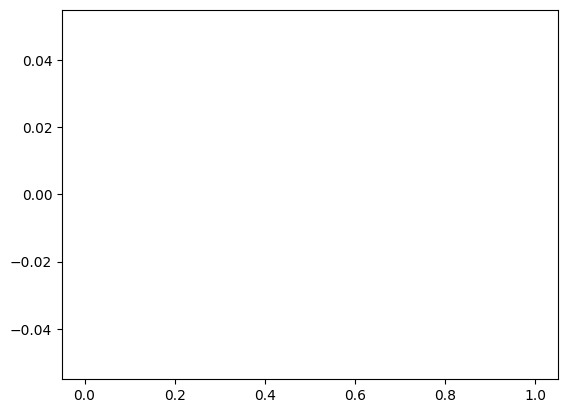




For column: Close
Summary Stats: 
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Close, dtype: float64


Missingness: 
0.0


Histogram:


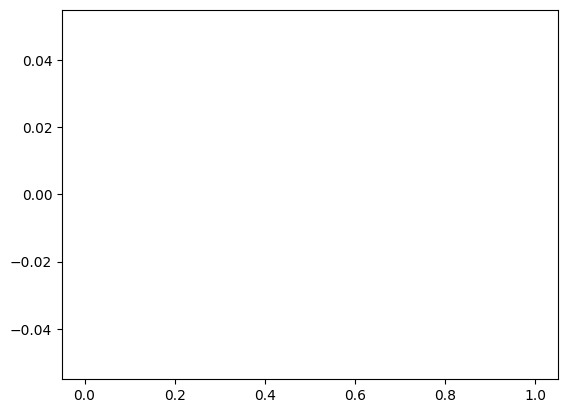




For column: Volume
Summary Stats: 
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Volume, dtype: float64


Missingness: 
0.0


Histogram:


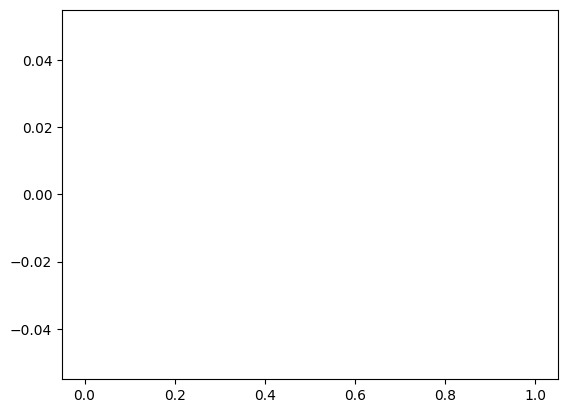




For column: Open Interest
Summary Stats: 
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Open Interest, dtype: float64


Missingness: 
0.0


Histogram:


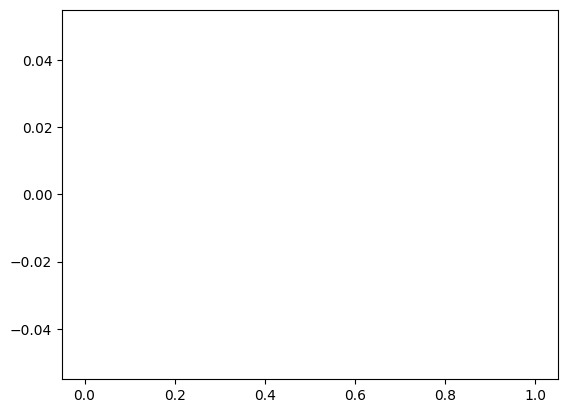

In [43]:
unique_tickers = daily_futures['Symbol'].unique()
for ticker in unique_tickers:
  print(f"\nTicker: \033[1m{ticker}\033[0m")
  ticker_df = process_input_df(df=daily_futures, symbol=ticker)
  summary_stats_and_hist(df=ticker_df)


In [ ]:
missingness = (
    daily_futures
    .groupby('Symbol')
    .apply(lambda g: g.isna().sum())
    .sort_index()
)
missingness

/tmp/ipython-input-1504102052.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.isna().sum())


,Symbol,Timestamp,Open,High,Low,Close,Volume,Open Interest,Date
Symbol,,,,,,,,,
FUT1,0,2,0,0,0,0,1,0,2
FUT10,0,0,0,0,0,0,0,0,0
FUT11,0,220,442,442,442,442,395,242,220
FUT12,0,440,587,587,587,587,574,440,440
FUT2,0,0,0,0,0,0,1,0,0
FUT3,0,0,0,0,0,0,1,0,0
FUT4,0,0,0,0,0,0,1,0,0
FUT5,0,0,0,0,0,0,0,0,0
FUT6,0,0,1,1,1,1,0,0,0


Also checking for duplicate time-stamps:

In [ ]:
ticker_timestamp_counts = dict()
for symbol in unique_tickers:
  ticker_df = daily_futures[daily_futures['Symbol'] == symbol]
  ticker_timestamp_counts[symbol] = [ticker_df['Timestamp'].nunique(), len(ticker_df['Timestamp']),
                                     ticker_df['Timestamp'].isna().sum()]

print("Ticker-Timestamp Counts")
pd.DataFrame(data=ticker_timestamp_counts).transpose().rename(columns={0: 'num_unique', 1: 'total', 2: 'nulls'})

Ticker-Timestamp Counts


,num_unique,total,nulls
FUT1,645,647,2
FUT2,647,647,0
FUT3,647,647,0
FUT4,647,647,0
FUT5,647,647,0
FUT6,647,647,0
FUT7,647,647,0
FUT8,647,647,0
FUT9,592,592,0
FUT10,388,388,0


##### Ticker-wise, as addressed earlier, the tables above indicate that missigness is seen reasonably in `FUT7`and `FUT8` and significantly in `FUT11` and `FUT12`.

Depending on industry, use-case etc., imputations (through central tendency statistics, grouped measures etc.), backfills, forwardfills are viable strategies but for financial data, especially for `Open`, `Close`, `Low`, `High` readings, it is **strongly discouraged** to impute values for securities like Options/Futures that are very volatile (even at intra-day) so **gaps may have to be an undesirable compromise** to prevent fatal factual inaccuracies.

**forward/back fills** may be handy for `Close` prices over the weekend/holidays perhaps where pricing data may technically not exist.


Mitigation for `Volume` and `Open Interest` may still seem conceivable, **forward/back fills may help but I prefer using rolling means to impute over, say a 5-day window** for more "context" for a *particular* ticker being a sorted time-series.

In [ ]:
fut1_df = daily_futures[daily_futures['Symbol'] == 'FUT1'].reset_index()
fut1_df.isna().sum().rename('Missingness').sort_values(ascending=False)

,Missingness
Date,2
Timestamp,2
Volume,1
index,0
Symbol,0
Open,0
Low,0
High,0
Close,0
Open Interest,0


In [ ]:
fut1_df[pd.isna(fut1_df['Timestamp'])]


,index,Symbol,Timestamp,Open,High,Low,Close,Volume,Open Interest,Date
645,6788,FUT1,NaN,76.625,77.125,76.625,76.625,287.0,3699.0,NaT
646,6789,FUT1,NaN,84.050,86.950,83.825,86.100,22548.0,57583.0,NaT


In [ ]:
fut1_df.iloc[640:651]

,index,Symbol,Timestamp,Open,High,Low,Close,Volume,Open Interest,Date
640,6734,FUT1,45863.0,6252.102144,108.800,107.375,108.575000,10633.000000,3.401200e+04,2025-07-25
641,6745,FUT1,45866.0,108.825000,108.850,108.075,108.350000,-489487.506166,3.268400e+04,2025-07-28
642,6755,FUT1,45867.0,108.250000,108.300,107.075,107.100000,11565.000000,1.000000e-08,2025-07-29
643,6766,FUT1,45868.0,107.550000,107.000,106.675,-387.918027,8214.000000,2.790900e+04,2025-07-30
644,6777,FUT1,45869.0,-996.834032,107.775,106.875,106.975000,5758.000000,2.626600e+04,2025-07-31
645,6788,FUT1,NaN,76.625000,77.125,76.625,76.625000,287.000000,3.699000e+03,NaT
646,6789,FUT1,NaN,84.050000,86.950,83.825,86.100000,22548.000000,5.758300e+04,NaT


In [ ]:
fut2_df = daily_futures[daily_futures['Symbol'] == 'FUT2']
fut2_df

,Symbol,Timestamp,Open,High,Low,Close,Volume,Open Interest,Date
1,FUT2,44929.0,95.275000,9.540000e+01,92.925,93.775,12549.0,4.872200e+04,2023-01-03
10,FUT2,44930.0,93.650000,9.502500e+01,92.500,92.525,12313.0,4.980500e+04,2023-01-04
20,FUT2,44931.0,-407.758361,9.285000e+01,90.800,91.725,10710.0,5.076200e+04,2023-01-05
30,FUT2,44932.0,91.400000,-1.000000e+10,89.575,89.825,14093.0,5.187900e+04,2023-01-06
39,FUT2,44935.0,89.750000,-7.177539e+03,89.600,90.850,19287.0,5.467300e+04,2023-01-09
...,...,...,...,...,...,...,...,...,...
6737,FUT2,45863.0,90.925000,9.117500e+01,90.525,89.450,23805.0,1.000000e+15,2025-07-25
6747,FUT2,45866.0,91.000000,9.100000e+01,89.900,90.675,14175.0,1.275620e+05,2025-07-28
6758,FUT2,45867.0,90.475000,9.047500e+01,88.325,88.525,22098.0,1.285110e+05,2025-07-29
6769,FUT2,45868.0,88.550000,8.970000e+01,88.025,89.300,20774.0,1.281020e+05,2025-07-30


In [ ]:
fut1_df_missing_vol = fut1_df[fut1_df['Volume'].isna()]
fut1_df_missing_vol

,index,Symbol,Timestamp,Open,High,Low,Close,Volume,Open Interest,Date
606,6354,FUT1,45813.0,100.25,100.9,100.0,100.75,NaN,-1.000000e+15,2025-06-05


In [ ]:
fut1_df.iloc[604:608]

,index,Symbol,Timestamp,Open,High,Low,Close,Volume,Open Interest,Date
604,6330,FUT1,45811.0,100.775,100.875,100.025,100.100,8271.0,2.488500e+04,2025-06-03
605,6342,FUT1,45812.0,100.300,100.425,99.925,99.925,8442.0,2.193700e+04,2025-06-04
606,6354,FUT1,45813.0,100.250,100.900,100.000,100.750,NaN,-1.000000e+15,2025-06-05
607,6366,FUT1,45814.0,101.175,102.700,101.150,102.600,7017.0,1.811200e+04,2025-06-06


## Custom-Filling and Rolling-Mean Imputations

For example, using a "forward fill" for `Volume` (although shouldn't be encouraged).

In [ ]:
def customized_fill(df: pd.DataFrame, method_type: str=['back', 'forward'], days: int=3, cols: list=[]) -> pd.DataFrame:
  result = df.copy()
  for col in cols:
    if method_type == 'forward':
      result[col] = result[col].ffill(limit=days)
    elif method_type == 'back':
      result[col] = result[col].bfill(limit=days)
    else:
      raise ValueError(f"Unrecognized parameter for method_type: {method_type}; pick between 'forward' or 'back'")
  return result


def n_day_rolling_mean_fill(df: pd.DataFrame, days: int=5, cols: list=[]) -> pd.DataFrame:
  result = df.copy()
  for col in cols:
    # identifying null indices in result
    null_idx = result[col].isna()

    # computing the rolling mean for the column with a window_size of 'days'
    # min_periods to ensure this works with a min window sample of 1 too.
    roll_mean = result[col].rolling(days, min_periods=1).mean()
    result.loc[null_idx, col] = roll_mean[null_idx]
  return result


In [ ]:
fut1_df.iloc[604:608]   # NaN for Volume at index=606

,index,Symbol,Timestamp,Open,High,Low,Close,Volume,Open Interest,Date
604,6330,FUT1,45811.0,100.775,100.875,100.025,100.100,8271.0,2.488500e+04,2025-06-03
605,6342,FUT1,45812.0,100.300,100.425,99.925,99.925,8442.0,2.193700e+04,2025-06-04
606,6354,FUT1,45813.0,100.250,100.900,100.000,100.750,NaN,-1.000000e+15,2025-06-05
607,6366,FUT1,45814.0,101.175,102.700,101.150,102.600,7017.0,1.811200e+04,2025-06-06


In [ ]:
customized_fill(df=fut1_df, method_type='forward', cols=['Volume']).iloc[604:608] # ffilled Volume at index=606


,index,Symbol,Timestamp,Open,High,Low,Close,Volume,Open Interest,Date
604,6330,FUT1,45811.0,100.775,100.875,100.025,100.100,8271.0,2.488500e+04,2025-06-03
605,6342,FUT1,45812.0,100.300,100.425,99.925,99.925,8442.0,2.193700e+04,2025-06-04
606,6354,FUT1,45813.0,100.250,100.900,100.000,100.750,8442.0,-1.000000e+15,2025-06-05
607,6366,FUT1,45814.0,101.175,102.700,101.150,102.600,7017.0,1.811200e+04,2025-06-06


In [ ]:
n_day_rolling_mean_fill(df=fut1_df, cols=['Volume'], days=5)[600:608]   # using 5-day-rolling-mean to impute Volume at index=606

,index,Symbol,Timestamp,Open,High,Low,Close,Volume,Open Interest,Date
600,6286,FUT1,45805.0,99.625,100.300,1.000000e-08,100.225,14198.0,3.092600e+04,2025-05-28
601,6297,FUT1,45806.0,100.000,100.550,9.985000e+01,100.025,7009.0,3.015800e+04,2025-05-29
602,6308,FUT1,45807.0,100.250,101.400,1.000250e+02,101.275,9370.0,2.928300e+04,2025-05-30
603,6319,FUT1,45810.0,101.525,101.750,1.002076e+04,100.750,7589.0,2.783600e+04,2025-06-02
604,6330,FUT1,45811.0,100.775,100.875,1.000250e+02,100.100,8271.0,2.488500e+04,2025-06-03
605,6342,FUT1,45812.0,100.300,100.425,9.992500e+01,99.925,8442.0,2.193700e+04,2025-06-04
606,6354,FUT1,45813.0,100.250,100.900,1.000000e+02,100.750,8418.0,-1.000000e+15,2025-06-05
607,6366,FUT1,45814.0,101.175,102.700,1.011500e+02,102.600,7017.0,1.811200e+04,2025-06-06


## Generating the Flagged dataset to highlight "illogical" or "outlier" rows

In [79]:
process_input_df(df=daily_futures, symbol='FUT1', just_flag=True)

,Symbol,Timestamp,Open,High,Low,Close,Volume,Open Interest,Date,illogical_flag,outlier_flag,is_illogical,is_Close_outlier,Logical_Flag,Outlier_Flag,is_logical,is_Open_outlier,is_High_outlier,is_Low_outlier,is_Volume_outlier,is_Open Interest_outlier
0,FUT1,44929.0,87.425000,87.975,85.275,84.600000,27911.000000,6.958700e+04,2023-01-03,False,True,1,False,True,False,False,False,False,False,False,False
9,FUT1,44930.0,84.875000,86.025,83.475,83.500000,25940.000000,6.798900e+04,2023-01-04,False,True,1,False,True,False,True,False,False,False,False,False
18,FUT1,44931.0,83.550000,83.975,81.600,82.675000,29058.000000,6.266000e+04,2023-01-05,False,True,1,False,True,False,True,False,False,False,False,False
28,FUT1,44932.0,82.325000,82.350,80.125,80.575000,28988.000000,-4.315699e+06,2023-01-06,False,True,1,False,True,False,False,False,False,False,False,True
38,FUT1,44935.0,80.350000,81.625,79.700,81.000000,31593.000000,5.969200e+04,2023-01-09,False,True,0,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6734,FUT1,45863.0,6252.102144,108.800,107.375,108.575000,10633.000000,3.401200e+04,2025-07-25,False,True,1,True,True,False,False,True,True,True,False,False
6745,FUT1,45866.0,108.825000,108.850,108.075,108.350000,-489487.506166,3.268400e+04,2025-07-28,True,True,1,True,True,False,False,True,True,True,True,False
6755,FUT1,45867.0,108.250000,108.300,107.075,107.100000,11565.000000,1.000000e-08,2025-07-29,False,False,1,True,True,False,True,True,True,True,False,False
6766,FUT1,45868.0,107.550000,107.000,106.675,-387.918027,8214.000000,2.790900e+04,2025-07-30,True,True,1,True,True,False,False,True,False,False,False,False


# OpenAI API Chaining for Incoming Data

In [74]:
OPENAI_API_KEY = ""

# initializing the gpt-4o model
llm = ChatOpenAI(
    model="gpt-4.1", #"gpt-4o-mini",
    temperature=0,
    api_key=OPENAI_API_KEY
)

# creating the agent
agent = create_pandas_dataframe_agent(
    llm,
    daily_futures,
    agent_type="openai-tools",
    tools=[summary_stats_and_hist, between_percentiles, add_logical_flag, add_outlier_flag],
    verbose=True,
    handle_parsing_errors=True,
    allow_dangerous_code=True
)


# optionally using "batch" for any tasks that can be invoked in parallel
# agent.batch(prompts)

# invoking the agent
prompt = """
1) Sort by 'Symbol' and 'Timestamp', both ascending.
2) Calculate and print out summary statistics for numeric columns.
3) Generate and save a csv formatted output dataframe, no need to display action inputs or reasoning.

You may use any appropriate helper methods specified in the "tools" parameter. Make sure to PRINT
summary statistics here.
"""
result = agent.invoke(prompt)
print(result["output"])


/usr/local/lib/python3.12/dist-packages/langchain_experimental/agents/agent_toolkits/pandas/base.py:283: UserWarning: Received additional kwargs {'tools': [<function summary_stats_and_hist at 0x794e7916bba0>, <function between_percentiles at 0x794e79168860>, <function add_logical_flag at 0x794e66c2d4e0>, <function add_outlier_flag at 0x794e7916b060>], 'handle_parsing_errors': True} which are no longer supported.
  warnings.warn(




> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "df = df.sort_values(['Symbol', 'Timestamp'], ascending=[True, True])\ndf.describe()"}`


          Timestamp          Open          High           Low         Close  \
count   6788.000000  6.325000e+03  6.325000e+03  6.325000e+03  6.325000e+03   
mean   45399.400707 -6.325537e+16 -3.171391e+17 -1.484146e+18 -1.119400e+14   
min    44929.000000 -1.000000e+20 -5.345185e+21 -5.940167e+21 -1.005687e+20   
25%    45156.000000  8.020000e+01  8.047500e+01  7.950000e+01  8.007500e+01   
50%    45398.000000  8.947500e+01  9.000000e+01  8.910000e+01  8.957500e+01   
75%    45637.000000  1.001000e+02  1.008500e+02  9.977500e+01  1.003750e+02   
max    45869.000000  1.000000e+20  4.843482e+21  1.000000e+20  1.000000e+20   
std      273.809411  6.887259e+18  9.137840e+19  9.144227e+19  7.546127e+18   

             Volume  Open Interest                           Date  \
count  6.392000e+03   6.705000e+03          

The output generated by the chain above

In [75]:
output_df = pd.read_csv('sorted_output.csv')
output_df

,Symbol,Timestamp,Open,High,Low,Close,Volume,Open Interest,Date,illogical_flag,outlier_flag,is_illogical,is_Close_outlier,Logical_Flag,Outlier_Flag
0,FUT1,44929.0,8.742500e+01,87.975000,85.275,8.460000e+01,27911.000000,6.958700e+04,2023-01-03,False,True,1,0,True,False
1,FUT1,44930.0,8.487500e+01,86.025000,83.475,8.350000e+01,25940.000000,6.798900e+04,2023-01-04,False,True,1,0,True,False
2,FUT1,44931.0,8.355000e+01,83.975000,81.600,8.267500e+01,29058.000000,6.266000e+04,2023-01-05,False,True,1,0,True,False
3,FUT1,44932.0,8.232500e+01,82.350000,80.125,8.057500e+01,28988.000000,-4.315699e+06,2023-01-06,False,True,1,0,True,False
4,FUT1,44935.0,8.035000e+01,81.625000,79.700,8.100000e+01,31593.000000,5.969200e+04,2023-01-09,False,True,0,0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7445,FUT9,45863.0,9.650000e+01,96.500000,95.700,1.000000e-08,49.000000,1.244000e+03,2025-07-25,False,True,1,1,True,False
7446,FUT9,45866.0,9.622500e+01,96.525000,96.200,9.642500e+01,1898.693245,1.242000e+03,2025-07-28,False,False,0,0,False,False
7447,FUT9,45867.0,9.620000e+01,96.200000,95.200,9.537500e+01,125.000000,1.293000e+03,2025-07-29,False,False,1,0,True,False
7448,FUT9,45868.0,-1.000000e+10,95.800000,95.150,-4.185126e+02,34.000000,1.292000e+03,2025-07-30,True,True,0,1,False,False


Generating summary statistics and visualizaitons (template could be used for incoming data)



> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "import matplotlib.pyplot as plt\nimport seaborn as sns\n\ndf_numeric = df[['Timestamp', 'Open', 'High', 'Low', 'Close', 'Open Interest', 'Volume']]\nfig, axes = plt.subplots(3, 3, figsize=(18, 12))\naxes = axes.flatten()\n\nfor i, col in enumerate(df_numeric.columns):\n    sns.histplot(df_numeric[col], kde=True, ax=axes[i], bins=30)\n    axes[i].set_title(f'Histogram of {col}')\nplt.tight_layout()\nplt.show()\n\n# Outlier detection using IQR\noutlier_ranges = {}\nfor col in df_numeric.columns:\n    Q1 = df_numeric[col].quantile(0.25)\n    Q3 = df_numeric[col].quantile(0.75)\n    IQR = Q3 - Q1\n    lower = Q1 - 1.5 * IQR\n    upper = Q3 + 1.5 * IQR\n    outlier_ranges[col] = (lower, upper)\noutlier_ranges"}`




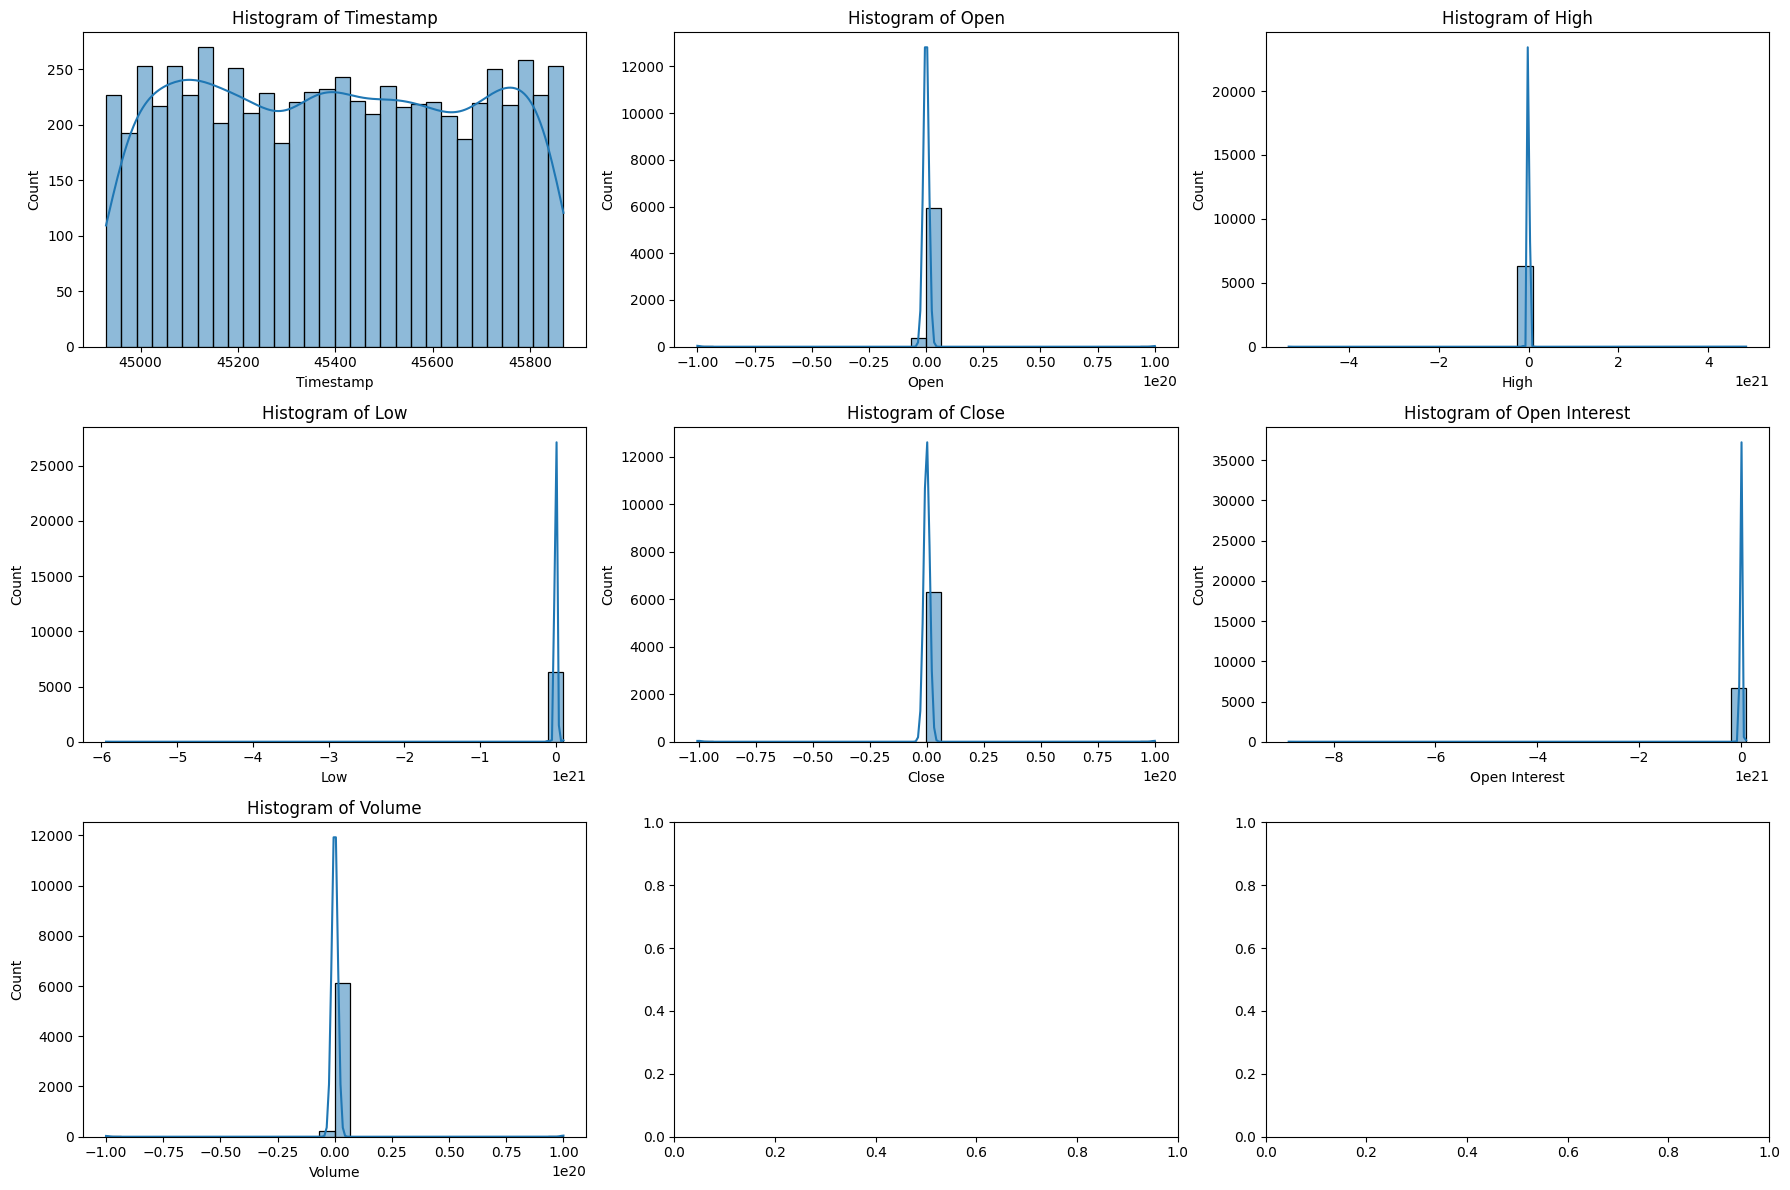

{'Timestamp': (np.float64(44434.5), np.float64(46358.5)), 'Open': (np.float64(50.350000000000016), np.float64(129.95)), 'High': (np.float64(49.912499999999994), np.float64(131.4125)), 'Low': (np.float64(49.08749999999999), np.float64(130.1875)), 'Close': (np.float64(49.62500000000001), np.float64(130.825)), 'Open Interest': (np.float64(-52227.0), np.float64(88661.0)), 'Volume': (np.float64(-11312.0), np.float64(19040.0))}
Invoking: `python_repl_ast` with `{'query': "df.describe(include='all').T"}`


                   count unique    top  freq                           mean  \
Symbol              7450     12   FUT1   647                            NaN   
Timestamp         6788.0    NaN    NaN   NaN                   45399.400707   
Open              6325.0    NaN    NaN   NaN           -63255374905436648.0   
High              6325.0    NaN    NaN   NaN          -317139103418120704.0   
Low               6325.0    NaN    NaN   NaN         -1484145560274855168.0   
Close             632

{'input': '\n\n1) Explain the distribution of data for all columns in the input df.\n2) You can create histograms for "Timestamp", "Open", "High", "Close", "Low", "Open Interest" and "Volume".\n3) Indicate the ranges at which outliers exist for each numerical column.\n\nYou do not need to output step-wise reasoning, prose or action inputs. You can simply output response text to the questions above or\ndisplay plots.\n\n',
 'output': '1) Distribution of Data (Summary Statistics):\n\n- Symbol: 12 unique symbols, most frequent is \'FUT1\'.\n- Timestamp: Ranges from 44,929 to 45,869, mean ≈ 45,399, std ≈ 274.\n- Open, High, Low, Close, Volume, Open Interest: These columns have extremely large negative and positive values, indicating the presence of significant outliers or possibly data entry errors. The means and standard deviations are extremely large, and the min/max values are far outside the typical range for financial data.\n- Date: Ranges from 2023-01-03 to 2025-07-31.\n- illogical_f

In [76]:
prompts = """

1) Explain the distribution of data for all columns in the input df.
2) You can create histograms for "Timestamp", "Open", "High", "Close", "Low", "Open Interest" and "Volume".
3) Indicate the ranges at which outliers exist for each numerical column.

You do not need to output step-wise reasoning, prose or action inputs. You can simply output response text to the questions above or
display plots.

"""
agent.invoke(prompts)

# Bonus Content

##### This might be a bit of a sidestep considering the scope of the assessment but using Moving Averages (MA) and Exponential Moving Averages (EMA) could help "smooth" out time-series data and help determine general trends.

##### Some of my past experience working with time-series equities data to study price action involved looking at MA/EMA "cross-overs" that may indicate trend reversals.

Helper methods like `moving_average`, `exponential_moving_average`, `time_period_ticker_statistics` and `plot_with_ma_ema` help with getting statistics like cumulative rate of return, general volatility etc.

#### Plotting `Close` for FUT1 with 20 day MA and EMA with returns, volatility stats

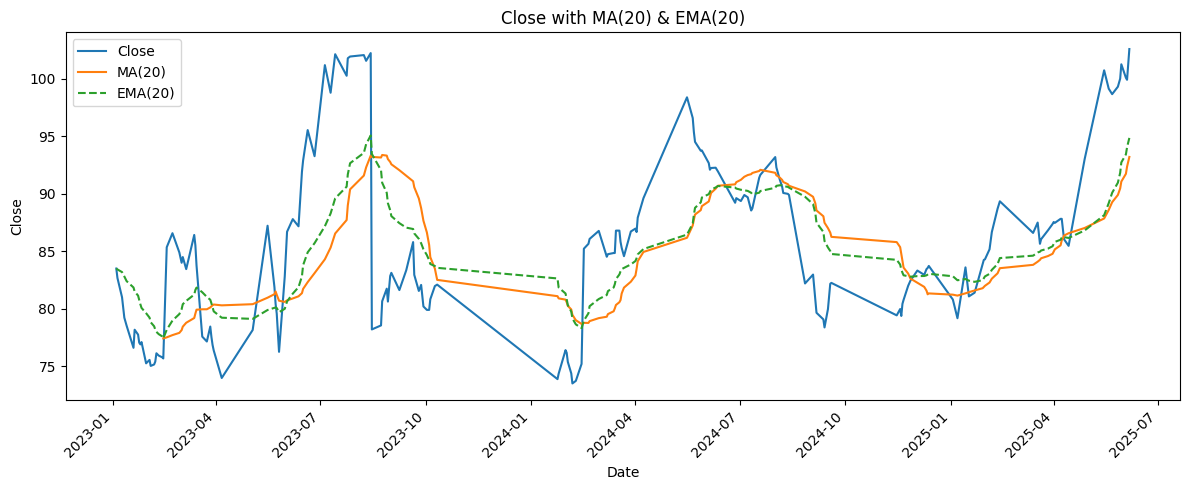

(<Figure size 1200x500 with 1 Axes>,
 <Axes: title={'center': 'Close with MA(20) & EMA(20)'}, xlabel='Date', ylabel='Close'>)

In [ ]:
plot_with_ma_ema(df=fut1_processed, date_col='Date', value_col='Close', day_window=20)

In [ ]:
time_period_ticker_statistics(df=fut1_processed, value_col='Close', day_window=10000)

{'Rate of Return for "Close"': np.float64(22.874251497005982),
 'Volatility / St. Dev for "Close"': 7.314532014742449,
 'Start': Timestamp('2023-01-04 00:00:00'),
 'End': Timestamp('2025-06-06 00:00:00')}

The same can be replicated for all other `Symbols` to determine relative performance.

Such as for **FUT10**:

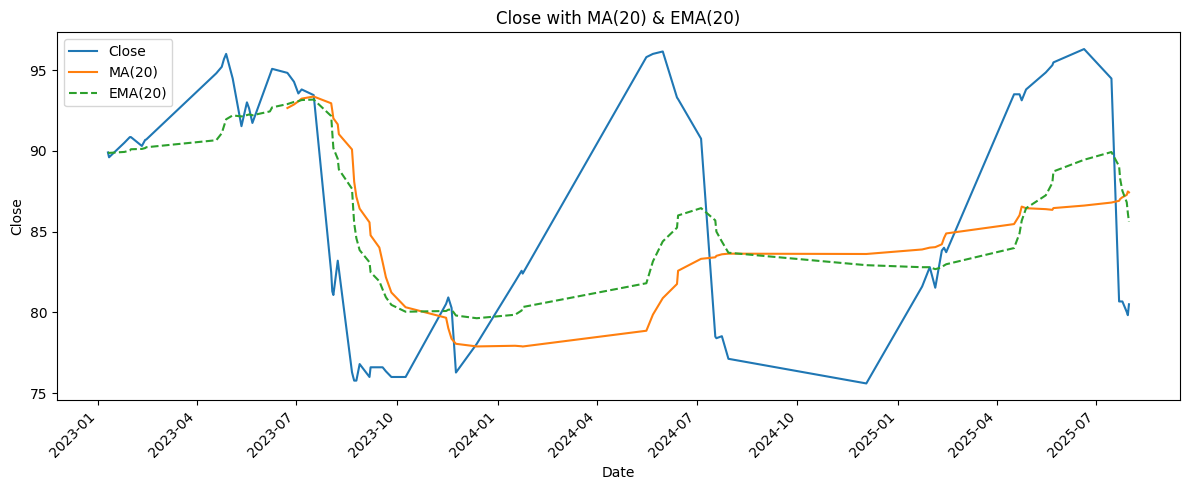

{'Rate of Return for "Close"': np.float64(-10.456062291434934),
 'Volatility / St. Dev for "Close"': 7.4336627719308135,
 'Start': Timestamp('2023-01-10 00:00:00'),
 'End': Timestamp('2025-07-31 00:00:00')}

In [ ]:
fut10 = process_input_df(df=daily_futures, symbol='FUT10')
plot_with_ma_ema(df=fut10, date_col='Date', value_col='Close', day_window=20)
time_period_ticker_statistics(df=fut10, value_col='Close', day_window=10000)